v3.

# Photometric Redshift Estimation

We will try to estimate the redshift from **DES** data using the match from the VVDS.

We use Machine Learning methods and Deep learning methods


In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Baixando Funções que serão usadas nesse notebook")
    ! shred -u astroFunctions.py
    ! wget https://raw.githubusercontent.com/zxcorr/zxcorr_DataAccess/main/DESzxcorr/pycode/astroFunctions.py -O astroFunctions.py
    ! wget
    ! pip install esutil
    ! pip install healpy
    import astroFunctions as astro
    from google.colab import drive
    drive.mount('/content/drive')
else:
    import sys,os
    home = os.getenv("HOME")
    sys.path.append(home+"/Projetos/PHOTOzxcorr/functions/") # user here the path where we download the folder DESzxcoorr
    
    

## Import Libraries

In [2]:
import logging 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import os,sys
import matplotlib
from astropy.io import ascii 
from astropy.table import Table
import seaborn as sns
import time

# Regression Libraries
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras import layers
from tensorflow.keras import regularizers


# Other Libraries
from sklearn.decomposition import PCA
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,RobustScaler
import category_encoders as ce
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split,ShuffleSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew #for some statistics


# Neural Network Libs
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from sklearn.metrics import confusion_matrix
import keras as ks
%matplotlib inline

## Functions

Some functions that it's importants

In [3]:
def clean_tab(tab,col,val):
    tab.drop(tab[tab[col]==val].index,inplace = True)
def tts_split(X,y,size):
    rs = ShuffleSplit(n_splits=5, test_size=size, random_state=0)
    rs.get_n_splits(X)
    for train_index, test_index in rs.split(X, y): 
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test,y_train, y_test

n_folds = 5

def rmsle_cv(model,X_train,y_train):
    kf = KFold(5, shuffle=True, random_state=None).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.ravel(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def rmse_ann(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def rmse_ann2(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def rmse_ann3(y_true, y_pred):
    return ks.backend.sqrt(ks.backend.mean(ks.backend.square(y_pred - y_true), axis=-1))
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

## Load the Data

In [4]:
if IN_COLAB:
    path1 = "/content/drive/Shareddrives/Optical Data/DES Data/match-des-ps2"
    path2 = "/content/drive/Shareddrives/Optical Data/DES Data/results/PSPixelFit_PS1_VIPERS_VVDS"
    path3 = "/content/drive/Shareddrives/Optical Data/DES Data/64"
else:
    path1 = home+"/Projetos/PHOTOzxcorr/data/des_vvds"
    path2 = home+"/Projetos/PHOTOzxcorr/data/vvds.fits"

In [5]:
filename1 = os.listdir(path1)
#filename2 = os.listdir(path2)
#filename3 = os.listdir(path3)

In [6]:
vvds = Table.read(path2).to_pandas()

In [7]:
l1 = []
for i in range(len(filename1)): # if breaks, its the RAM so read less data.
    path_dir = os.path.join(path1,filename1[i])
    df = Table.read(path_dir).to_pandas()
    l1.append(df)
des = pd.concat(l1, axis=0, ignore_index=True)
del df,l1

#l1 = []
#for i in range(len(filename2)): # if breaks, its the RAM so read less data.
#    path_dir = os.path.join(path2,filename2[i])
#    df = Table.read(path_dir).to_pandas()
#    l1.append(df)
#vvds = pd.concat(l1, axis=0, ignore_index=True)
#del df,l1

#l1= []
#for i in range(len(filename2)): # if breaks, its the RAM so read less data.
#    path_dir = os.path.join(path2,filename2[i])
#    df = Table.read(path_dir).to_pandas()
#    l1.append(df)
#ps = pd.concat(l1, axis=0, ignore_index=True)
#del df,l1

In [8]:
des.head()

COADD_OBJECT_ID         TILENAME  HPIX_32  HPIX_64  HPIX_1024  HPIX_4096  \
0        104665233  b'DES0219-0541'     4422    17689    4528640   72458240   
1        110140506  b'DES0221-0416'     4422    17689    4528622   72457966   
2        110141276  b'DES0221-0416'     4422    17689    4528622   72457962   
3        110141600  b'DES0221-0416'     4422    17689    4528622   72457960   
4        110142890  b'DES0221-0416'     4422    17689    4528619   72457914   

   HPIX_16384         RA       DEC  ALPHAWIN_J2000  ...  SPREADERR_MODEL_G  \
0  1159331840  34.452509 -5.376883       34.452509  ...           0.000934   
1  1159327464  35.623279 -4.388962       35.623279  ...           0.012087   
2  1159327404  35.608125 -4.404374       35.608125  ...           0.009313   
3  1159327371  35.612266 -4.411218       35.612266  ...           0.006501   
4  1159326638  35.560879 -4.440139       35.560879  ...           0.000440   

   SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  \
0           0.000562           0.000566           0.000829           0.002365   
1           0.003399           0.002264           0.002455           0.006365   
2           0.006066           0.004834           0.006624           0.014340   
3           0.003061           0.001976           0.002048           0.004460   
4           0.001246           0.001589           0.002014           0.004566   

   WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  \
0                 0.00192                0.000748                0.001186   
1               -99.00000              -99.000000                0.002392   
2               -99.00000              -99.000000              -99.000000   
3               -99.00000                0.006813                0.001997   
4               -99.00000              -99.000000              -99.000000   

   WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
0                0.001678                0.002032  
1                0.002708              -99.000000  
2              -99.000000              -99.000000  
3                0.002202              -99.000000  
4              -99.000000              -99.000000  

[5 rows x 213 columns]

In [9]:
des.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163350 entries, 0 to 163349
Columns: 213 entries, COADD_OBJECT_ID to WAVG_SPREADERR_MODEL_Y
dtypes: float64(181), int64(31), object(1)
memory usage: 265.5+ MB


In [10]:
des.describe()

COADD_OBJECT_ID        HPIX_32        HPIX_64     HPIX_1024  \
count     1.633500e+05  163350.000000  163350.000000  1.633500e+05   
mean      2.092855e+08    6101.555476   24407.900380  6.248550e+06   
std       1.197361e+08    2201.373192    8805.736368  2.254269e+06   
min       1.046652e+08    4420.000000   17683.000000  4.526848e+06   
25%       1.174796e+08    4421.000000   17686.000000  4.527762e+06   
50%       1.189020e+08    4423.000000   17692.000000  4.529193e+06   
75%       3.643316e+08    8983.000000   35935.000000  9.199527e+06   
max       3.703735e+08    8989.000000   35957.000000  9.205247e+06   

          HPIX_4096    HPIX_16384             RA            DEC  \
count  1.633500e+05  1.633500e+05  163350.000000  163350.000000   
mean   9.997681e+07  1.599629e+09      42.635446     -13.185605   
std    3.606830e+07  5.770928e+08       7.995037      11.020984   
min    7.242957e+07  1.158873e+09      34.452509     -28.616850   
25%    7.244420e+07  1.159107e+09      36.386004     -27.377954   
50%    7.246709e+07  1.159473e+09      37.035594      -5.191638   
75%    1.471924e+08  2.355079e+09      52.835624      -4.658498   
max    1.472840e+08  2.356543e+09      54.135857      -3.587948   

       ALPHAWIN_J2000  DELTAWIN_J2000  ...  SPREADERR_MODEL_G  \
count   163350.000000   163350.000000  ...       1.633500e+05   
mean        42.635446      -13.185605  ...       2.279510e+01   
std          7.995037       11.020984  ...       7.276598e+03   
min         34.452509      -28.616850  ...       0.000000e+00   
25%         36.386003      -27.377954  ...       2.256399e-03   
50%         37.035594       -5.191638  ...       4.074190e-03   
75%         52.835624       -4.658498  ...       6.467353e-03   
max         54.135857       -3.587948  ...       2.873334e+06   

       SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  \
count      163350.000000      163350.000000      163350.000000   
mean            0.022745           0.003520           0.414989   
std             5.182623           0.002544          73.385282   
min             0.000000           0.000014           0.000000   
25%             0.001327           0.001479           0.002037   
50%             0.002690           0.002989           0.004134   
75%             0.004452           0.005097           0.006972   
max          1546.559570           0.032680       19221.845703   

       SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
count       1.633500e+05           163350.000000           163350.000000   
mean        1.706121e+03              -48.512487              -26.040607   
std         5.997045e+05               49.491753               43.590119   
min         0.000000e+00              -99.000000              -99.000000   
25%         6.331537e-03              -99.000000              -99.000000   
50%         1.180025e-02                0.000267                0.001362   
75%         1.820478e-02                0.002438                0.002780   
max         2.418781e+08                1.093628                0.640645   

       WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  
count           163350.000000           163350.000000           163350.000000  
mean               -29.513987              -43.611171              -81.097598  
std                 45.287936               49.150183               38.103917  
min                -99.000000              -99.000000              -99.000000  
25%                -99.000000              -99.000000              -99.000000  
50%                  0.001285                0.000671              -99.000000  
75%                  0.002761                0.002576              -99.000000  
max                  0.295300                0.356951                0.191141  

[8 rows x 212 columns]

In [11]:
vvds.head()

ID       RA_1     DEC_1      z  z_Err  flag        source  \
0  b'020095413'  36.554878 -4.800845  0.871 -9.999  b'3'  b'VVDS_DEEP'   
1  b'020091652'  36.567375 -4.811272  0.382 -9.999  b'3'  b'VVDS_DEEP'   
2  b'020090930'  36.537343 -4.813442  0.266 -9.999  b'4'  b'VVDS_DEEP'   
3  b'020087832'  36.518992 -4.819152  0.244 -9.999  b'4'  b'VVDS_DEEP'   
4  b'020088050'  36.596351 -4.817919  0.519 -9.999  b'4'  b'VVDS_DEEP'   

  comments  totobs  totexp  ...  SPREADERR_MODEL_R SPREADERR_MODEL_I  \
0     b'-'      -9      -9  ...           0.001221          0.001351   
1     b'-'      -9      -9  ...           0.001045          0.000933   
2     b'-'      -9      -9  ...           0.000733          0.001063   
3     b'-'      -9      -9  ...           0.000934          0.001672   
4     b'-'      -9      -9  ...           0.000708          0.000680   

   SPREADERR_MODEL_Z  SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  \
0           0.001825           0.007033                0.075774   
1           0.001148           0.004134                0.003761   
2           0.001801           0.005727                0.001133   
3           0.003042           0.008880                0.001366   
4           0.000949           0.003293                0.002572   

   WAVG_SPREADERR_MODEL_R  WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  \
0                0.001306                0.001532                0.001939   
1                0.001091                0.000989                0.001242   
2                0.000771                0.001113                0.001759   
3                0.000995                0.001808                0.003627   
4                0.000740                0.000726                0.000920   

   WAVG_SPREADERR_MODEL_Y    random  
0              -99.000000  0.510718  
1                0.004153  0.424861  
2              -99.000000  0.140826  
3              -99.000000  0.973567  
4                0.002905  0.914822  

[5 rows x 224 columns]

In [12]:
vvds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Columns: 224 entries, ID to random
dtypes: float32(2), float64(184), int32(2), int64(31), object(5)
memory usage: 4.7+ MB


In [13]:
originalTam = len(vvds)

In [14]:
vvds.describe()

RA_1        DEC_1            z        z_Err  totobs  totexp  \
count  2747.000000  2747.000000  2747.000000  2747.000000  2747.0  2747.0   
mean     39.736774    -8.878014     0.627864    -9.999001    -9.0    -9.0   
std       6.445019     9.120529     0.294641     0.000000     0.0     0.0   
min      36.261836   -27.988080     0.000000    -9.999000    -9.0    -9.0   
25%      36.531056    -4.735831     0.415000    -9.999000    -9.0    -9.0   
50%      36.696350    -4.541919     0.624000    -9.999000    -9.0    -9.0   
75%      36.909045    -4.395760     0.827000    -9.999000    -9.0    -9.0   
max      53.298710    -4.139604     3.607000    -9.999000    -9.0    -9.0   

       COADD_OBJECT_ID      HPIX_32       HPIX_64     HPIX_1024  ...  \
count     2.747000e+03  2747.000000   2747.000000  2.747000e+03  ...   
mean      1.643872e+08  5280.964689  21124.715690  5.408018e+06  ...   
std       9.725444e+07  1782.997090   7132.967974  1.826079e+06  ...   
min       1.142332e+08  4420.000000  17683.000000  4.527102e+06  ...   
25%       1.174743e+08  4423.000000  17692.000000  4.529161e+06  ...   
50%       1.174817e+08  4423.000000  17692.000000  4.529190e+06  ...   
75%       1.186442e+08  4423.000000  17692.000000  4.529253e+06  ...   
max       3.663375e+08  8989.000000  35957.000000  9.205014e+06  ...   

       SPREADERR_MODEL_R  SPREADERR_MODEL_I  SPREADERR_MODEL_Z  \
count        2747.000000        2747.000000        2747.000000   
mean            0.002498           0.002856           0.004574   
std             0.001772           0.002013           0.019254   
min             0.000087           0.000083           0.000095   
25%             0.001150           0.001280           0.001884   
50%             0.002116           0.002420           0.003461   
75%             0.003452           0.003948           0.005763   
max             0.012821           0.012288           1.000000   

       SPREADERR_MODEL_Y  WAVG_SPREADERR_MODEL_G  WAVG_SPREADERR_MODEL_R  \
count        2747.000000             2747.000000             2747.000000   
mean            0.444738              -37.983564              -13.008047   
std            13.275124               48.152377               33.454556   
min             0.000299              -99.000000              -99.000000   
25%             0.006048              -99.000000                0.000735   
50%             0.010752                0.001208                0.001689   
75%             0.017196                0.002695                0.002866   
max           570.853210                0.383664                0.295451   

       WAVG_SPREADERR_MODEL_I  WAVG_SPREADERR_MODEL_Z  WAVG_SPREADERR_MODEL_Y  \
count             2747.000000             2747.000000             2747.000000   
mean               -16.648142              -32.613656              -79.069552   
std                 37.036535               46.541170               39.705609   
min                -99.000000              -99.000000              -99.000000   
25%                  0.000618              -99.000000              -99.000000   
50%                  0.001724                0.001391              -99.000000   
75%                  0.002950                0.003030              -99.000000   
max                  0.007727                0.022461                0.046013   

            random  
count  2747.000000  
mean      0.497936  
std       0.286611  
min       0.000522  
25%       0.253766  
50%       0.499494  
75%       0.744739  
max       0.999671  

[8 rows x 219 columns]

**Counting the Galaxies of our Catalog**

In [15]:
pix = des['HPIX_1024'].unique()
pix_match = vvds["HPIX_1024"].unique()

In [16]:
num_des = []
avg_des = []
num_vvds = []
avg_vvds = []
for i in range(len(pix)):
    avg_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].mean())
    num_des.append(des[des['HPIX_1024']==pix[i]]['MAG_AUTO_I'].count())
for i in range(len(pix_match)):  
    avg_vvds.append(vvds[vvds['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].mean())
    num_vvds.append(vvds[vvds['HPIX_1024']==pix_match[i]]['MAG_AUTO_I'].count())

In [17]:
avg_des = np.asarray(avg_des)
num_des = np.asarray(num_des)

avg_vvds = np.asarray(avg_vvds)
num_vvds = np.asarray(num_vvds)

In [18]:
galaxies_des = pd.DataFrame(pix,columns=['HPIX_1024'])
galaxies_vvds = pd.DataFrame(pix_match,columns=['HPIX_1024'])
galaxies_des['AVG_des'] = avg_des
galaxies_des['COUNT_des'] = num_des
galaxies_vvds['AVG_vvds'] = avg_vvds
galaxies_vvds['COUNT_vvds'] = num_vvds

In [19]:
galaxies_vvds.head()

HPIX_1024   AVG_vvds  COUNT_vvds
0    4527103  21.668137          11
1    4527102  21.228073           1
2    4527851  21.166721           6
3    4527850  21.810902           9
4    4527849  22.049538           3

In [20]:
galaxies_des.head()

HPIX_1024    AVG_des  COUNT_des
0    4528640  19.105974          1
1    4528622  22.408955        155
2    4528619  21.868400        111
3    4528617  21.913652         63
4    4528618  21.941772        105

In [21]:
print("Galaxies in VVDSxDES match: ",galaxies_vvds['COUNT_vvds'].sum(),"\n Galaxies in Des",galaxies_des['COUNT_des'].sum())

Galaxies in VVDSxDES match:  2747 
 Galaxies in Des 163350


In [22]:
pix_des = galaxies_des.HPIX_1024.values
pix_vvds = galaxies_vvds.HPIX_1024.values

In [23]:
diff = np.setdiff1d(pix_des,pix_vvds)
diff

array([4526848, 4526849, 4526850, ..., 9205245, 9205246, 9205247])

In [24]:
num_des = []
avg_des = []
for i in range(len(pix_vvds)):
    avg_des.append(des[des['HPIX_1024']==pix_vvds[i]]['MAG_AUTO_I'].mean())
    num_des.append(des[des['HPIX_1024']==pix_vvds[i]]['MAG_AUTO_I'].count())

In [25]:
avg_des = np.asarray(avg_des)
num_des = np.asarray(num_des)


In [26]:
galaxies_desd = pd.DataFrame(pix_vvds,columns=['HPIX_1024'])
galaxies_desd['AVG_des'] = avg_des
galaxies_desd['COUNT_des'] = num_des

In [27]:
print("Galaxies contained in the DES catalogue",galaxies_desd['COUNT_des'].sum())

Galaxies contained in the DES catalogue 22636


In [28]:
print("Galaxies that are not contained in the match",galaxies_desd['COUNT_des'].sum()-galaxies_vvds["COUNT_vvds"].sum())

Galaxies that are not contained in the match 19889


In [29]:
# Calcular as galaxias que não estão no match do vvds.

In [30]:
print("We have {:f}% of the galaxie with the match".format(100*((galaxies_desd['COUNT_des'].sum()-galaxies_vvds["COUNT_vvds"].sum())/galaxies_desd['COUNT_des'].sum())))

We have 87.864464% of the galaxie with the match


**Before the cleaning**

In [31]:
count1, n1 = np.histogram(des['MAG_AUTO_R'],bins = np.linspace(0,30,100))
count2, n2 = np.histogram(vvds['MAG_AUTO_R'],bins = np.linspace(0,30,100))

<ipython-input-32-9100a005af15>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(n2[:-1],(count2/count1))


Text(0.5, 0, 'Object in  MAG_AUTO_R')

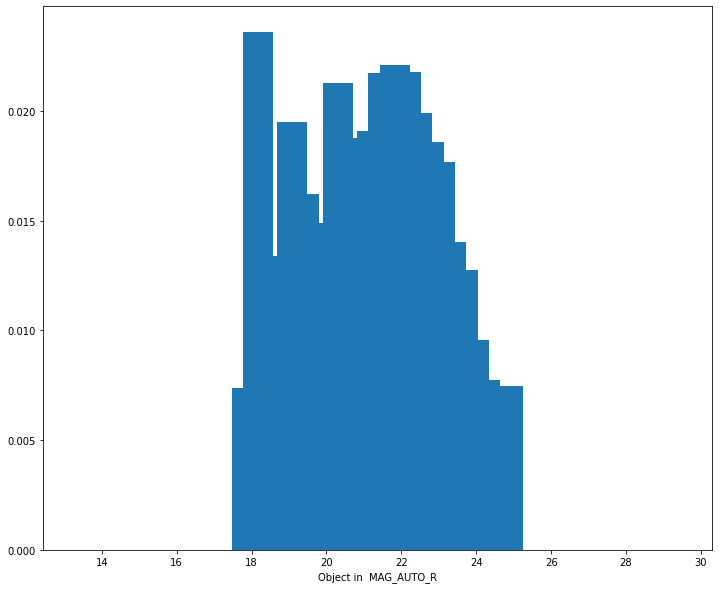

In [32]:
plt.figure(figsize=(12,10))
plt.bar(n2[:-1],(count2/count1))
plt.xlabel("Object in  MAG_AUTO_R")
#plt.ylim(0.8)

## Processing the data

We have some parts of our data that are **null**(not measured) values,

In [33]:
feat = ['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
            "WAVG_SPREAD_MODEL_G","WAVG_SPREAD_MODEL_R","WAVG_SPREAD_MODEL_I","WAVG_SPREAD_MODEL_Z","WAVG_SPREAD_MODEL_Y",
            "WAVG_FLUX_PSF_G","WAVG_FLUX_PSF_R","WAVG_FLUX_PSF_I","WAVG_FLUX_PSF_Z","WAVG_FLUX_PSF_Y",
            "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"]


In [34]:
vvds[(vvds[feat[0]]==99) | (vvds[feat[0]]==-99)][feat[0]]

199     99.0
415     99.0
452     99.0
479     99.0
810     99.0
1010    99.0
1389    99.0
1474    99.0
1591    99.0
1830    99.0
2026    99.0
2746    99.0
Name: MAG_AUTO_G, dtype: float64

In [35]:
for j in feat:
    print(j,":",len(vvds[(vvds[j]==99) | (vvds[j]==-99)][j]),"\n")

MAG_AUTO_G : 12 

MAG_AUTO_R : 1 

MAG_AUTO_I : 1 

MAG_AUTO_Z : 4 

MAG_AUTO_Y : 128 

WAVG_SPREAD_MODEL_G : 1054 

WAVG_SPREAD_MODEL_R : 361 

WAVG_SPREAD_MODEL_I : 462 

WAVG_SPREAD_MODEL_Z : 905 

WAVG_SPREAD_MODEL_Y : 2194 

WAVG_FLUX_PSF_G : 1054 

WAVG_FLUX_PSF_R : 361 

WAVG_FLUX_PSF_I : 462 

WAVG_FLUX_PSF_Z : 905 

WAVG_FLUX_PSF_Y : 2194 

WAVG_MAG_PSF_G : 1054 

WAVG_MAG_PSF_R : 361 

WAVG_MAG_PSF_I : 462 

WAVG_MAG_PSF_Z : 905 

WAVG_MAG_PSF_Y : 2194 



We have seen the null values of a data.

It is necessary to treat the data, to do so , first we want to maintain $95\%-97\%$ of our original data



In [36]:
for i in feat:
    print(i," is ",100*len(vvds[(vvds[i]==99) | (vvds[i]==-99)][j])/len(vvds),"%")

MAG_AUTO_G  is  0.43684018929741536 %
MAG_AUTO_R  is  0.03640334910811795 %
MAG_AUTO_I  is  0.03640334910811795 %
MAG_AUTO_Z  is  0.1456133964324718 %
MAG_AUTO_Y  is  4.659628685839097 %
WAVG_SPREAD_MODEL_G  is  38.36912995995632 %
WAVG_SPREAD_MODEL_R  is  13.14160902803058 %
WAVG_SPREAD_MODEL_I  is  16.81834728795049 %
WAVG_SPREAD_MODEL_Z  is  32.94503094284674 %
WAVG_SPREAD_MODEL_Y  is  79.86894794321077 %
WAVG_FLUX_PSF_G  is  38.36912995995632 %
WAVG_FLUX_PSF_R  is  13.14160902803058 %
WAVG_FLUX_PSF_I  is  16.81834728795049 %
WAVG_FLUX_PSF_Z  is  32.94503094284674 %
WAVG_FLUX_PSF_Y  is  79.86894794321077 %
WAVG_MAG_PSF_G  is  38.36912995995632 %
WAVG_MAG_PSF_R  is  13.14160902803058 %
WAVG_MAG_PSF_I  is  16.81834728795049 %
WAVG_MAG_PSF_Z  is  32.94503094284674 %
WAVG_MAG_PSF_Y  is  79.86894794321077 %


Therefore, we have the percentage of null values in our dataset.

Here I make a choice for a our data, but first we make a further analysis.


In [37]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].mean()

20.420951318999528

In [38]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].median()

20.60011100769043

In [39]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].std()

0.6542119271078598

In [40]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].min()

17.937219619750977

In [41]:
vvds[vvds["WAVG_MAG_PSF_Y"]!=99]["WAVG_MAG_PSF_Y"].max()

21.42400550842285

Here we make one choice, change the values of $99$ for the median values of the WAVG_MAG_PSF_Y

In [42]:
vvds.loc[vvds[feat[15]]==99,feat[15]] = vvds[vvds[feat[15]]!=99][feat[15]].max()
vvds.loc[vvds[feat[16]]==99,feat[16]] = vvds[vvds[feat[16]]!=99][feat[16]].max()
vvds.loc[vvds[feat[17]]==99,feat[17]] = vvds[vvds[feat[17]]!=99][feat[17]].max()
vvds.loc[vvds[feat[18]]==99,feat[18]] = vvds[vvds[feat[18]]!=99][feat[18]].max()
vvds.loc[vvds[feat[19]]==99,feat[19]] = vvds[vvds[feat[19]]!=99][feat[19]].max()

In [43]:
for i in feat:
    print(i," is ",100*len(vvds[(vvds[i]==99) | (vvds[i]==-99)][j])/len(vvds),"%")

MAG_AUTO_G  is  0.43684018929741536 %
MAG_AUTO_R  is  0.03640334910811795 %
MAG_AUTO_I  is  0.03640334910811795 %
MAG_AUTO_Z  is  0.1456133964324718 %
MAG_AUTO_Y  is  4.659628685839097 %
WAVG_SPREAD_MODEL_G  is  38.36912995995632 %
WAVG_SPREAD_MODEL_R  is  13.14160902803058 %
WAVG_SPREAD_MODEL_I  is  16.81834728795049 %
WAVG_SPREAD_MODEL_Z  is  32.94503094284674 %
WAVG_SPREAD_MODEL_Y  is  79.86894794321077 %
WAVG_FLUX_PSF_G  is  38.36912995995632 %
WAVG_FLUX_PSF_R  is  13.14160902803058 %
WAVG_FLUX_PSF_I  is  16.81834728795049 %
WAVG_FLUX_PSF_Z  is  32.94503094284674 %
WAVG_FLUX_PSF_Y  is  79.86894794321077 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


In [44]:
vvds.loc[vvds[feat[4]]==99,feat[4]] = vvds[vvds[feat[4]]!=99][feat[4]].median()
vvds.loc[vvds[feat[0]]==99,feat[0]] = vvds[vvds[feat[0]]!=99][feat[0]].median()
#vvds.loc[vvds[feat[3]]==99,feat[3]] = vvds[vvds[feat[3]]!=99][feat[3]].max()


In [45]:
for i in feat:
    print(i," is ",100*len(vvds[(vvds[i]==99) | (vvds[i]==-99)][j])/len(vvds),"%")

MAG_AUTO_G  is  0.0 %
MAG_AUTO_R  is  0.03640334910811795 %
MAG_AUTO_I  is  0.03640334910811795 %
MAG_AUTO_Z  is  0.1456133964324718 %
MAG_AUTO_Y  is  0.0 %
WAVG_SPREAD_MODEL_G  is  38.36912995995632 %
WAVG_SPREAD_MODEL_R  is  13.14160902803058 %
WAVG_SPREAD_MODEL_I  is  16.81834728795049 %
WAVG_SPREAD_MODEL_Z  is  32.94503094284674 %
WAVG_SPREAD_MODEL_Y  is  79.86894794321077 %
WAVG_FLUX_PSF_G  is  38.36912995995632 %
WAVG_FLUX_PSF_R  is  13.14160902803058 %
WAVG_FLUX_PSF_I  is  16.81834728795049 %
WAVG_FLUX_PSF_Z  is  32.94503094284674 %
WAVG_FLUX_PSF_Y  is  79.86894794321077 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


In [46]:
for j in feat[1:4]:
    clean_tab(vvds,j,99)

In [47]:
print("With this choice we maintain",100*(len(vvds)/originalTam))

With this choice we maintain 99.8179832544594


In [48]:
for i in feat:
    print(i," is ",100*len(vvds[(vvds[i]==99) | (vvds[i]==-99)][j])/len(vvds),"%")

MAG_AUTO_G  is  0.0 %
MAG_AUTO_R  is  0.0 %
MAG_AUTO_I  is  0.0 %
MAG_AUTO_Z  is  0.0 %
MAG_AUTO_Y  is  0.0 %
WAVG_SPREAD_MODEL_G  is  38.25674690007294 %
WAVG_SPREAD_MODEL_R  is  13.019693654266959 %
WAVG_SPREAD_MODEL_I  is  16.703136396790665 %
WAVG_SPREAD_MODEL_Z  is  32.822757111597376 %
WAVG_SPREAD_MODEL_Y  is  79.83223924142962 %
WAVG_FLUX_PSF_G  is  38.25674690007294 %
WAVG_FLUX_PSF_R  is  13.019693654266959 %
WAVG_FLUX_PSF_I  is  16.703136396790665 %
WAVG_FLUX_PSF_Z  is  32.822757111597376 %
WAVG_FLUX_PSF_Y  is  79.83223924142962 %
WAVG_MAG_PSF_G  is  0.0 %
WAVG_MAG_PSF_R  is  0.0 %
WAVG_MAG_PSF_I  is  0.0 %
WAVG_MAG_PSF_Z  is  0.0 %
WAVG_MAG_PSF_Y  is  0.0 %


## Plots

Some plot to understand, the best features to use

The features choose for our analysis is


* **WAVG_FLUX_PSF_G,R,I,Z,Y Weighted average flux measurement of PSF fit single epoch detections [ADU]**
* **MAG_AUTO_G,R,I,Z,Y Magnitude estimation, for an elliptical model based on the Kron radius [mag]**
* **WAVG_SPREAD_MODEL_G,R,I,Z,Y SPREAD MODEL using the weighted averaged values from single epoch detections**
* **WAVG_MAG_PSF_G,R,I,Z,Y Weighted average magnitude, of PSF fit single epoch detections [mag]**

**Plots for the completeza**

In [46]:
count1, n1 = np.histogram(des['MAG_AUTO_R'],bins = np.linspace(0,30,100))
count2, n2 = np.histogram(vvds['MAG_AUTO_R'],bins = np.linspace(0,30,100))

<ipython-input-47-9100a005af15>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.bar(n2[:-1],(count2/count1))


Text(0.5, 0, 'Object in  MAG_AUTO_R')

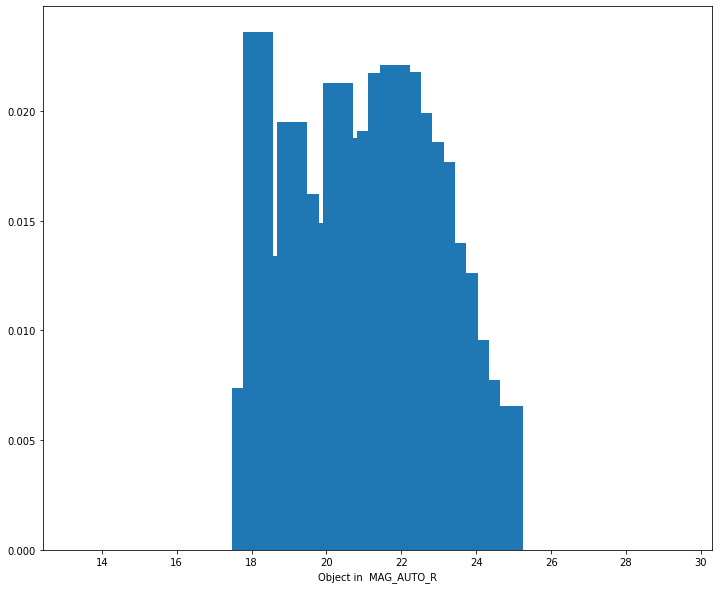

In [47]:
plt.figure(figsize=(12,10))
plt.bar(n2[:-1],(count2/count1))
plt.xlabel("Object in  MAG_AUTO_R")
#plt.ylim(0.8)

In [48]:
feat.append("z")

<Figure size 2880x2304 with 0 Axes>

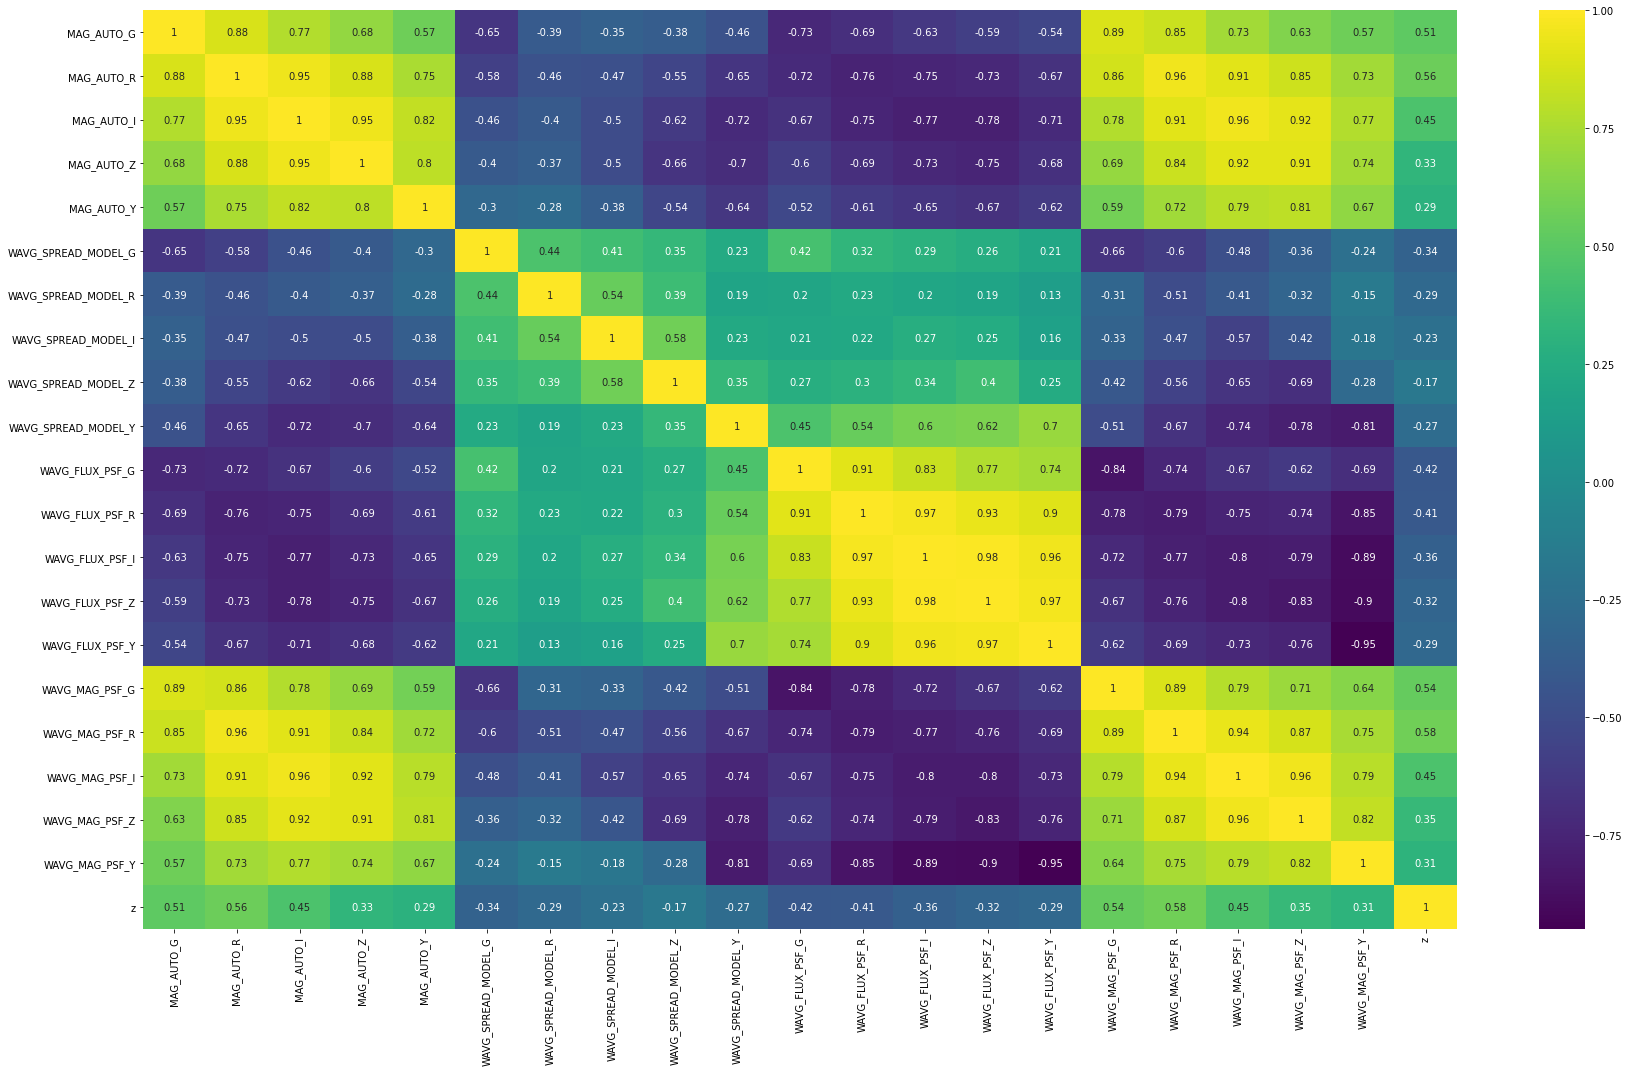

In [49]:
plt.figure(figsize=(40,32))
corrmat = vvds[feat].corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat,annot=True,cmap="viridis")
plt.tight_layout()

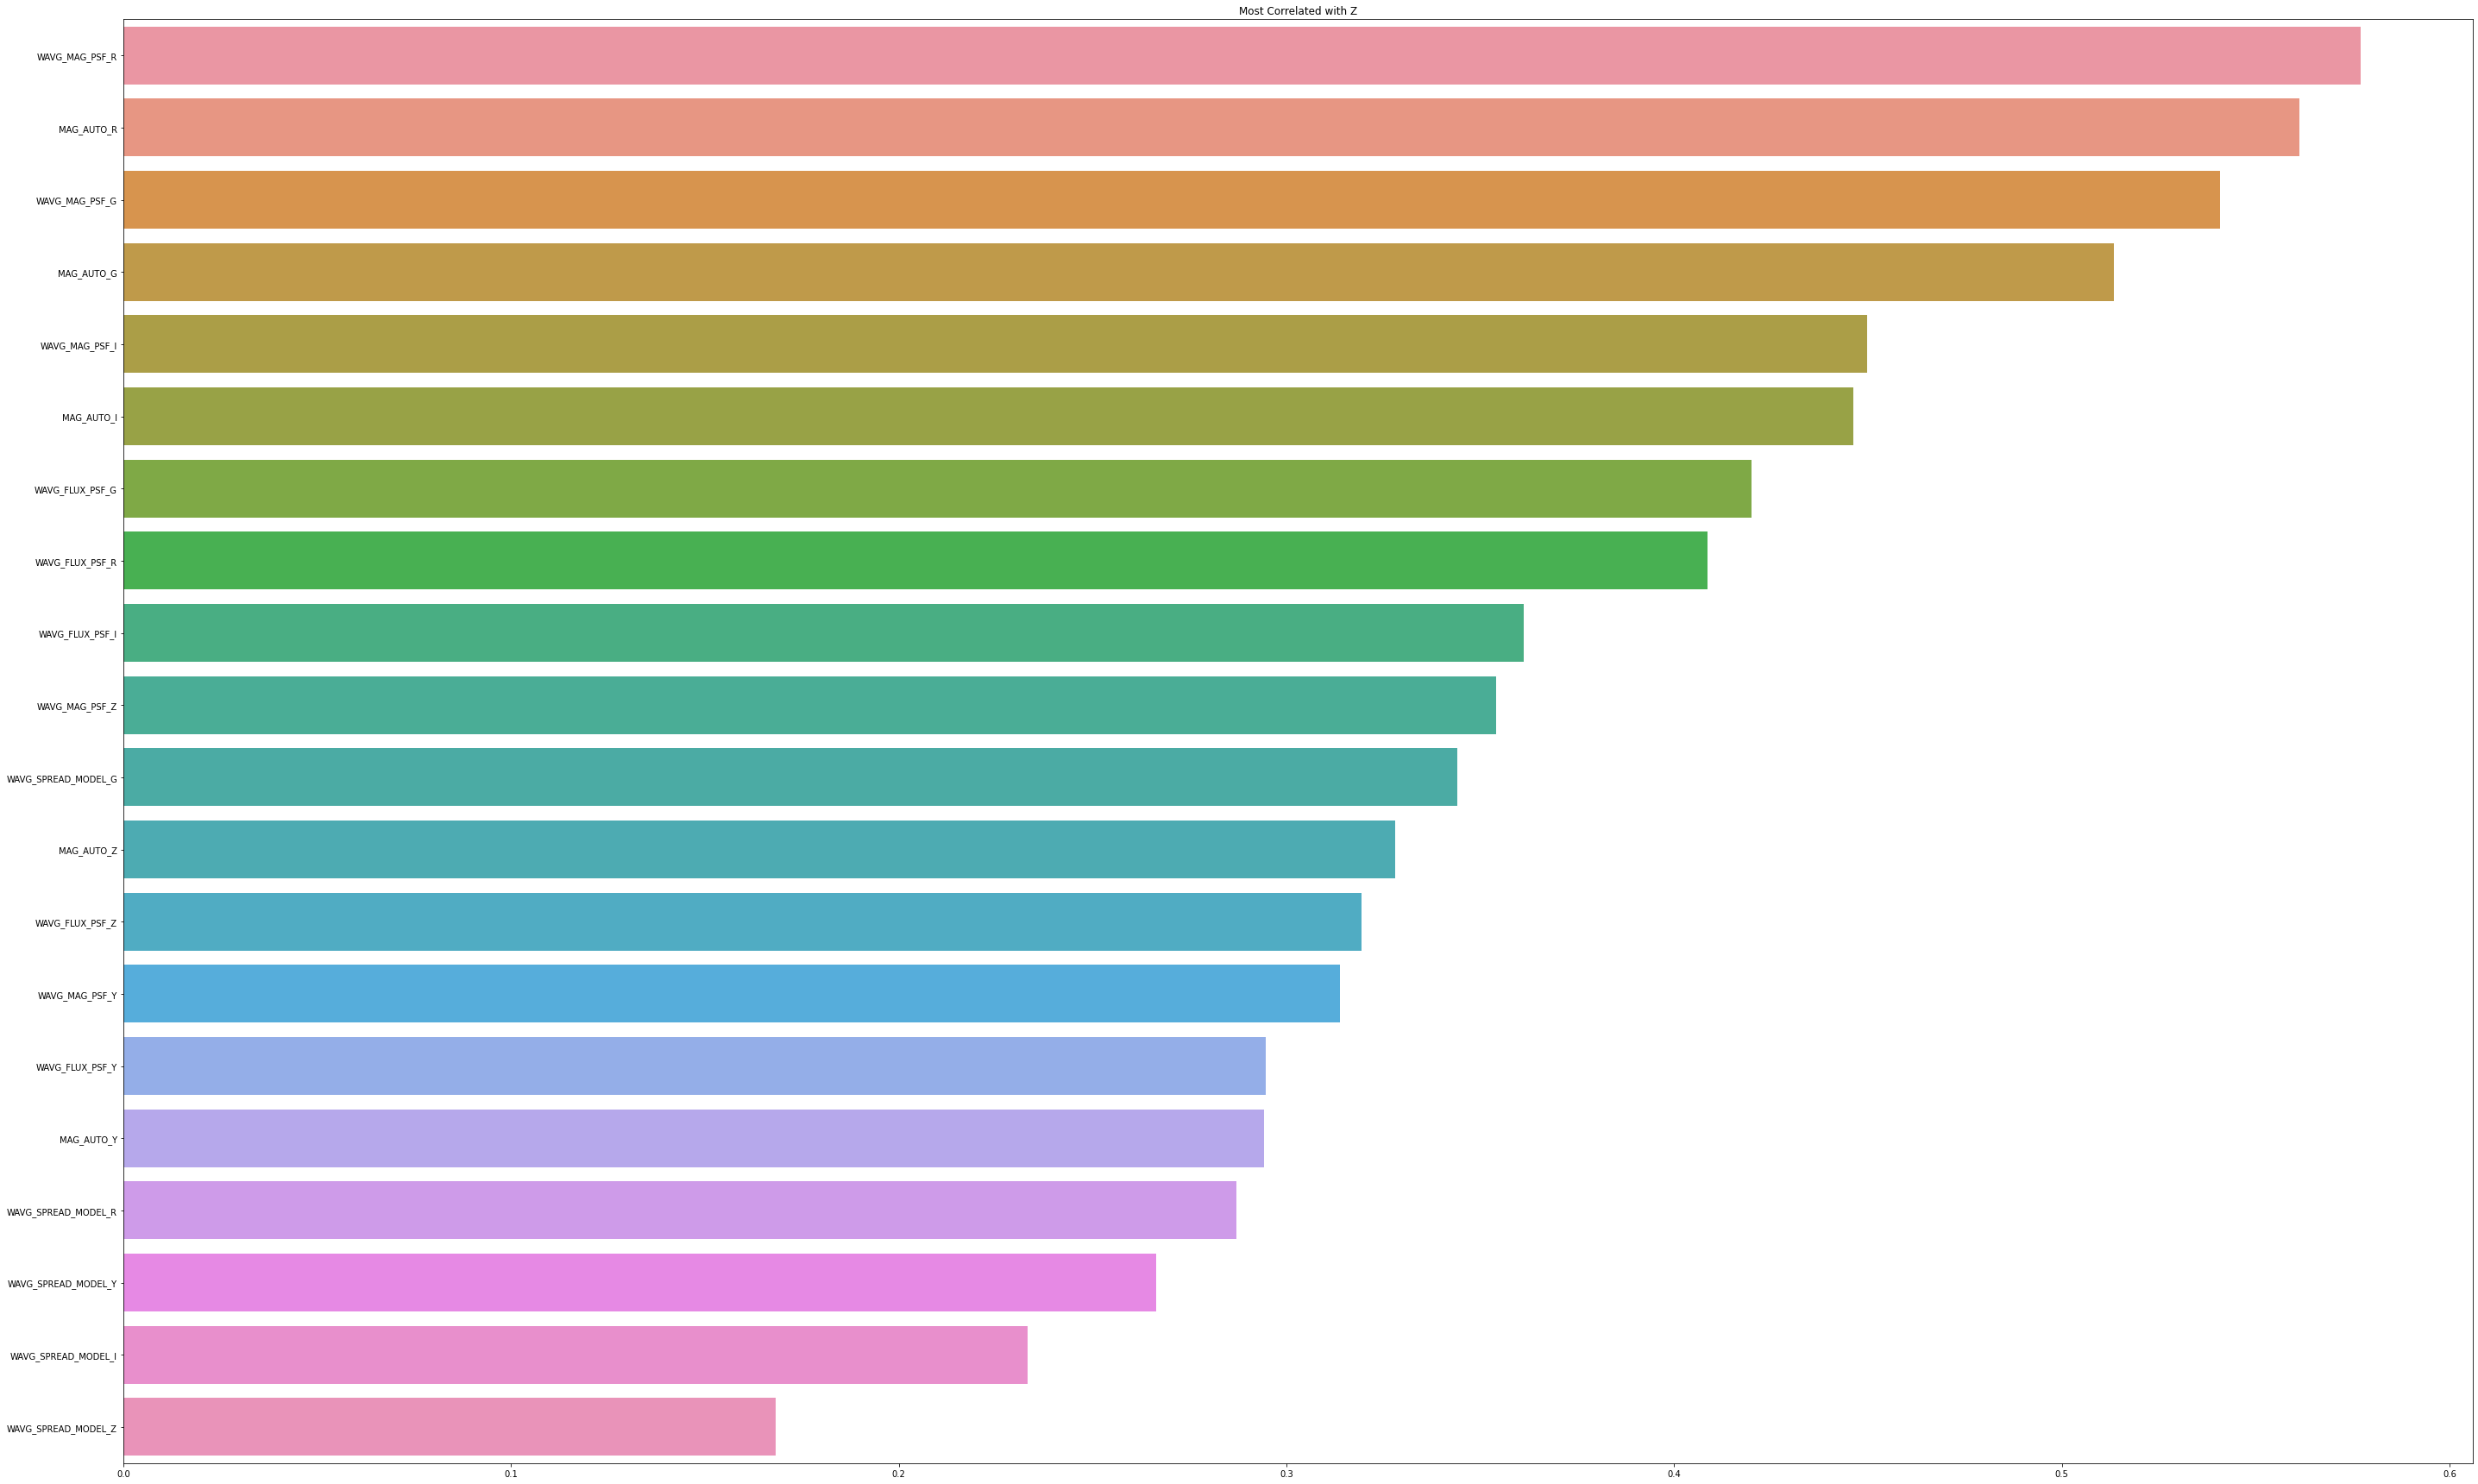

In [50]:
plt.figure(figsize=(40,24))
correlations =corrmat.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()
plt.savefig("correlations.png",dpi = 500,bbox_inches = "tight" )

<Figure size 1152x576 with 0 Axes>

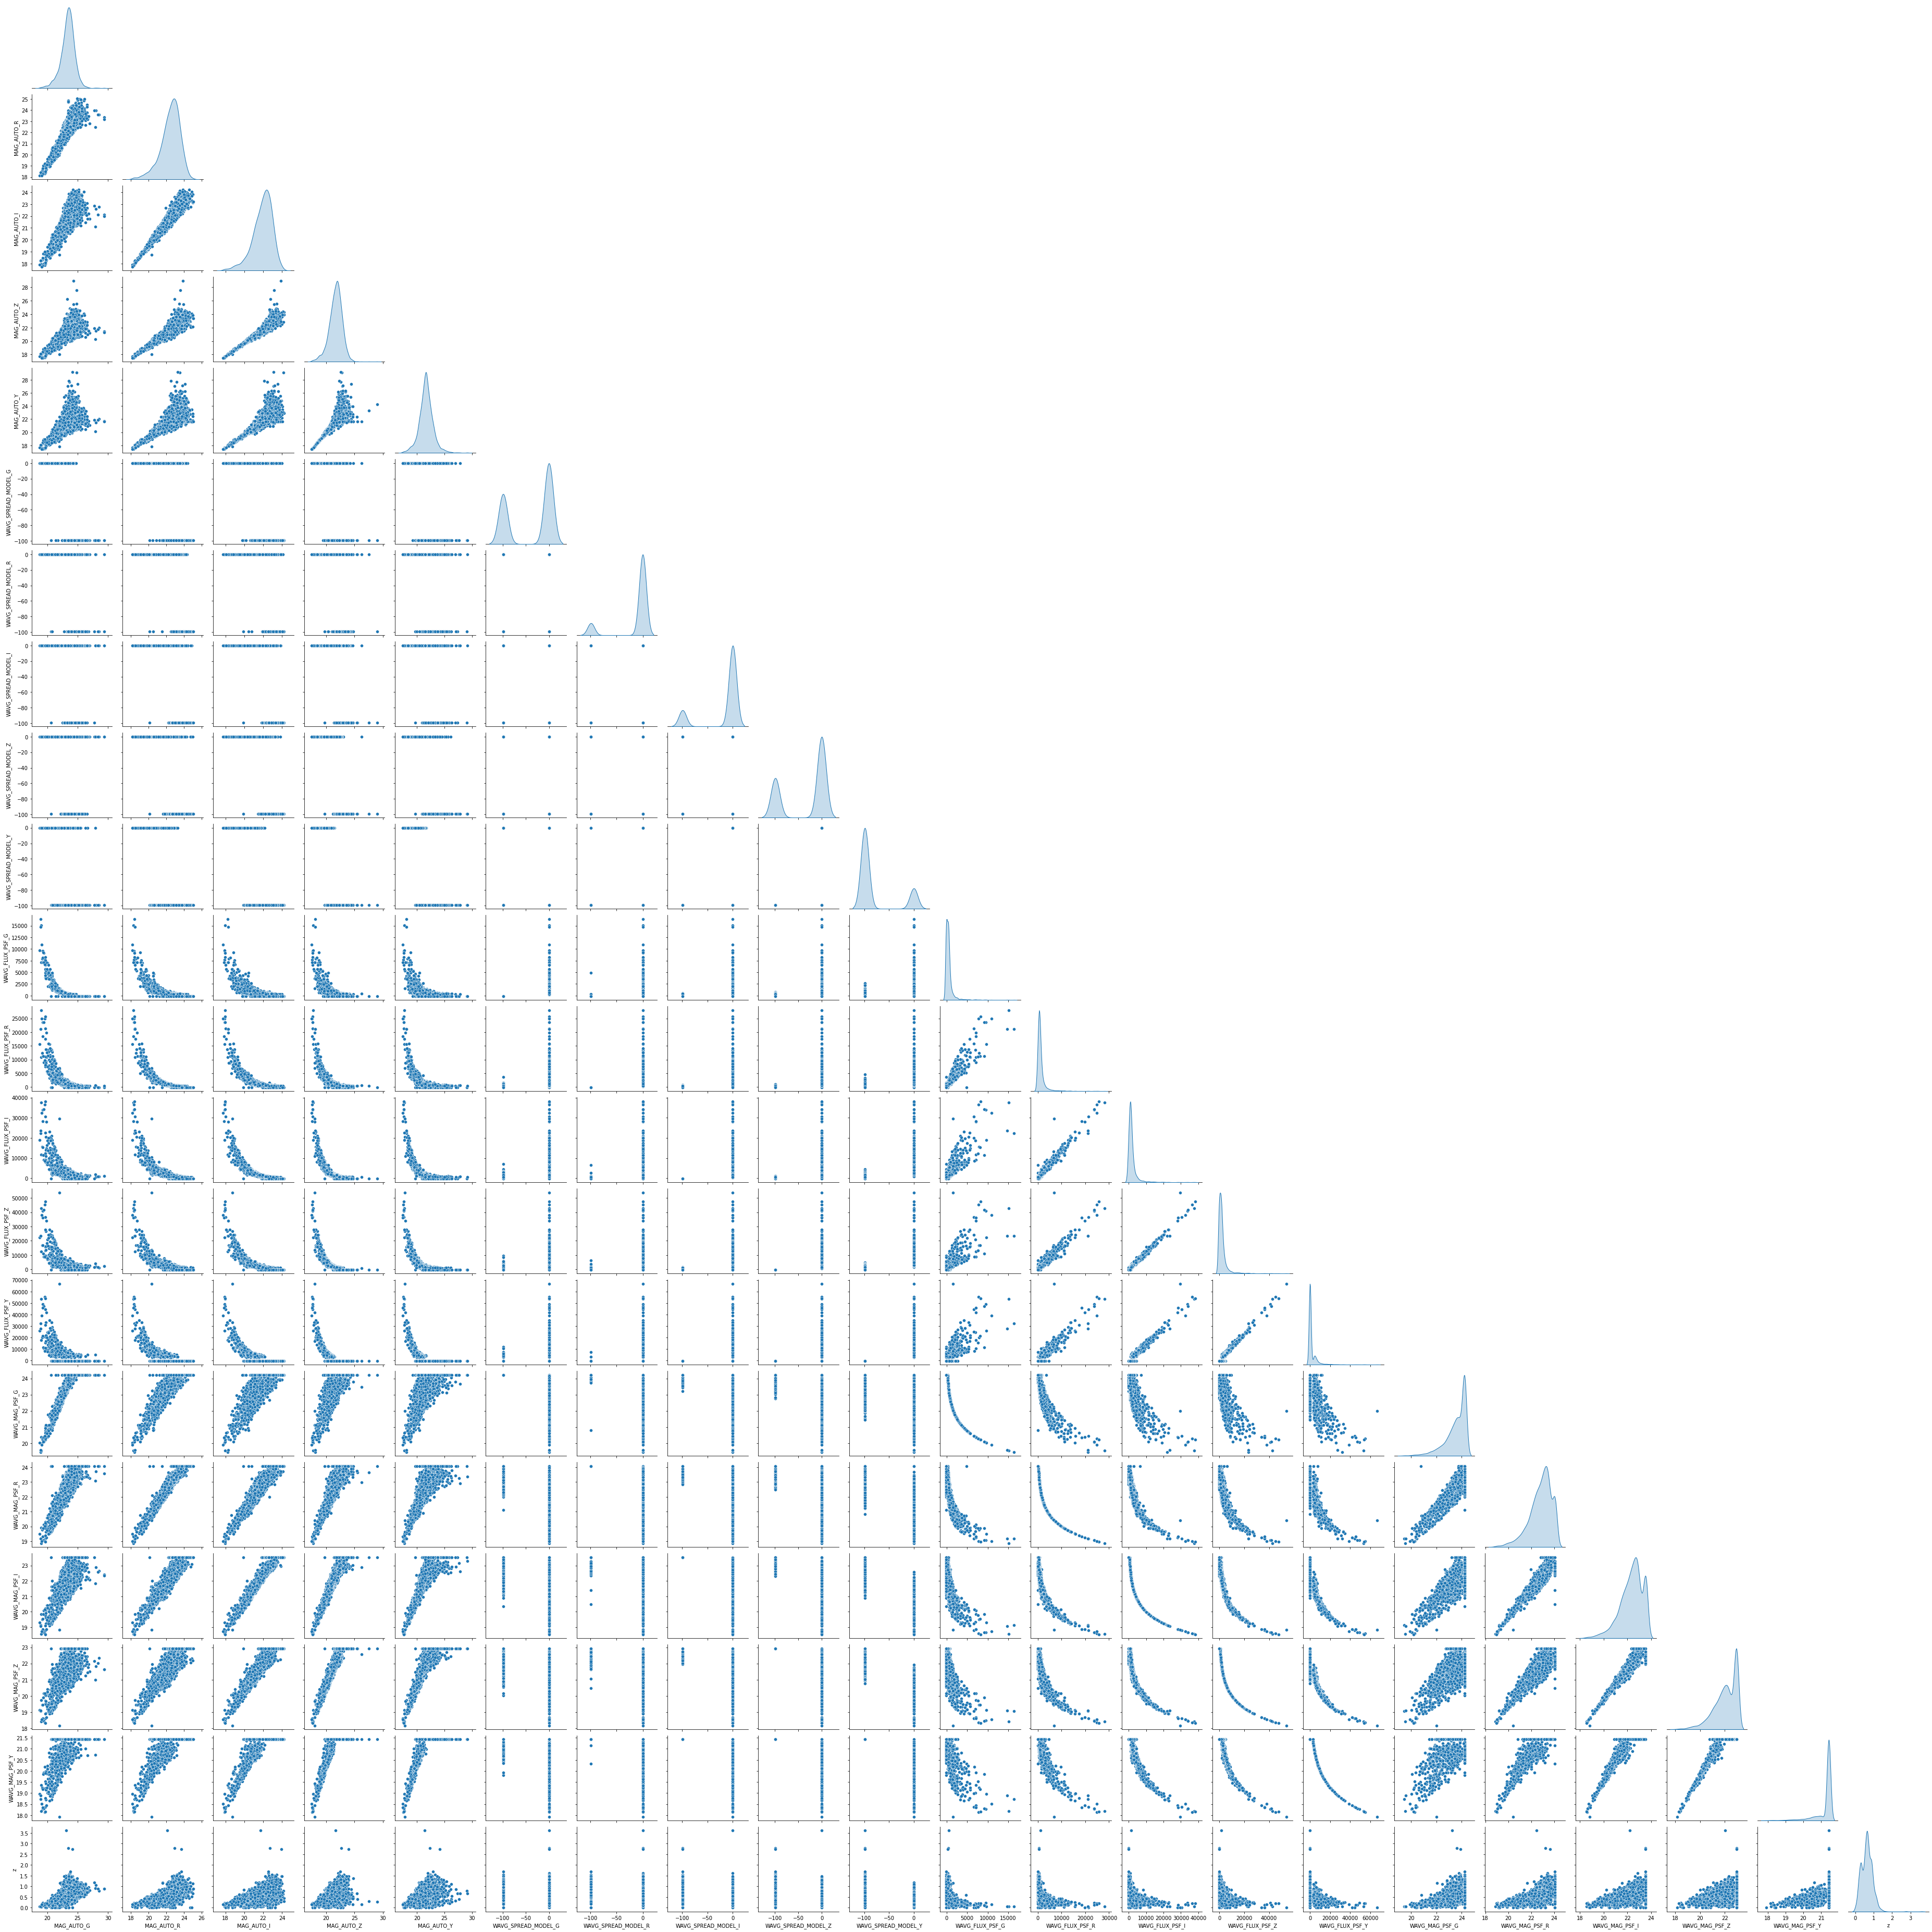

In [51]:
plt.figure(figsize=(16,8))
sns.pairplot(vvds[feat],diag_kind= "kde",corner= True)

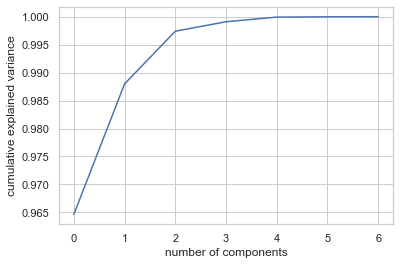

None

Cumulative Variance Ratio  Explained Variance Ratio
0                   0.964658                  0.964658
1                   0.987974                  0.023316
2                   0.997381                  0.009406
3                   0.999077                  0.001697
4                   0.999908                  0.000830
5                   0.999958                  0.000050
6                   0.999979                  0.000021

In [52]:
pca_test = PCA(n_components=7)
pca_test.fit(vvds[feat[0:19]])
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=2, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [53]:
pca = PCA(n_components=5)

In [54]:
new_feat = pca.fit_transform(vvds[feat[0:19]])


In [55]:
new_components = pd.DataFrame(new_feat,columns=["1 Component","2 Component","3 Component","4 Component","5 Component"])

In [56]:
new_components["z"] = vvds["z"]

In [57]:
new_components.head()

1 Component  2 Component  3 Component  4 Component  5 Component      z
0 -1231.312144  -958.070960   799.711010   279.291813    87.472641  0.871
1  3619.481031  1481.321798    -0.615399   289.542737   -29.194735  0.382
2  -502.498533 -1815.899125   720.370987   -12.698734    25.580890  0.266
3 -1445.226038 -1266.677119    58.985353   -23.396767   -83.658083  0.244
4  5016.972034  1130.800625   328.611439   -25.672182    65.953381  0.519

<Figure size 1152x864 with 0 Axes>

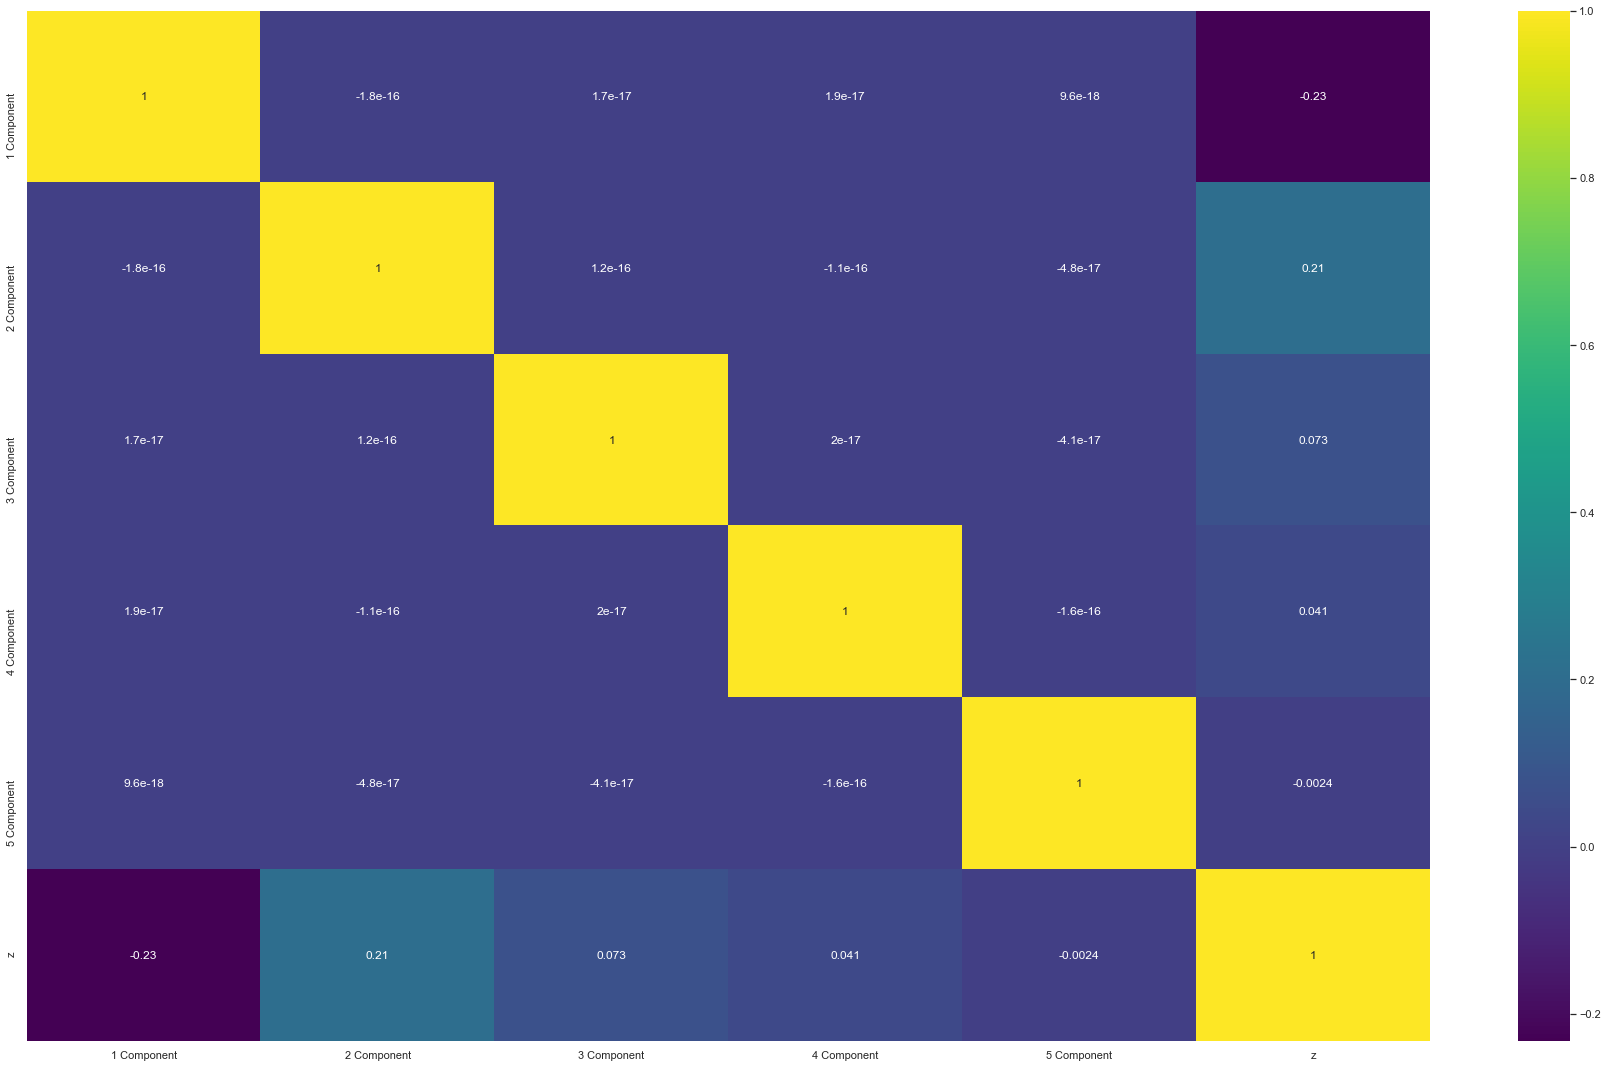

In [58]:
plt.figure(figsize=(16,12))
corrmat1 = new_components.corr()
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(corrmat1,annot=True,cmap="viridis")
plt.tight_layout()

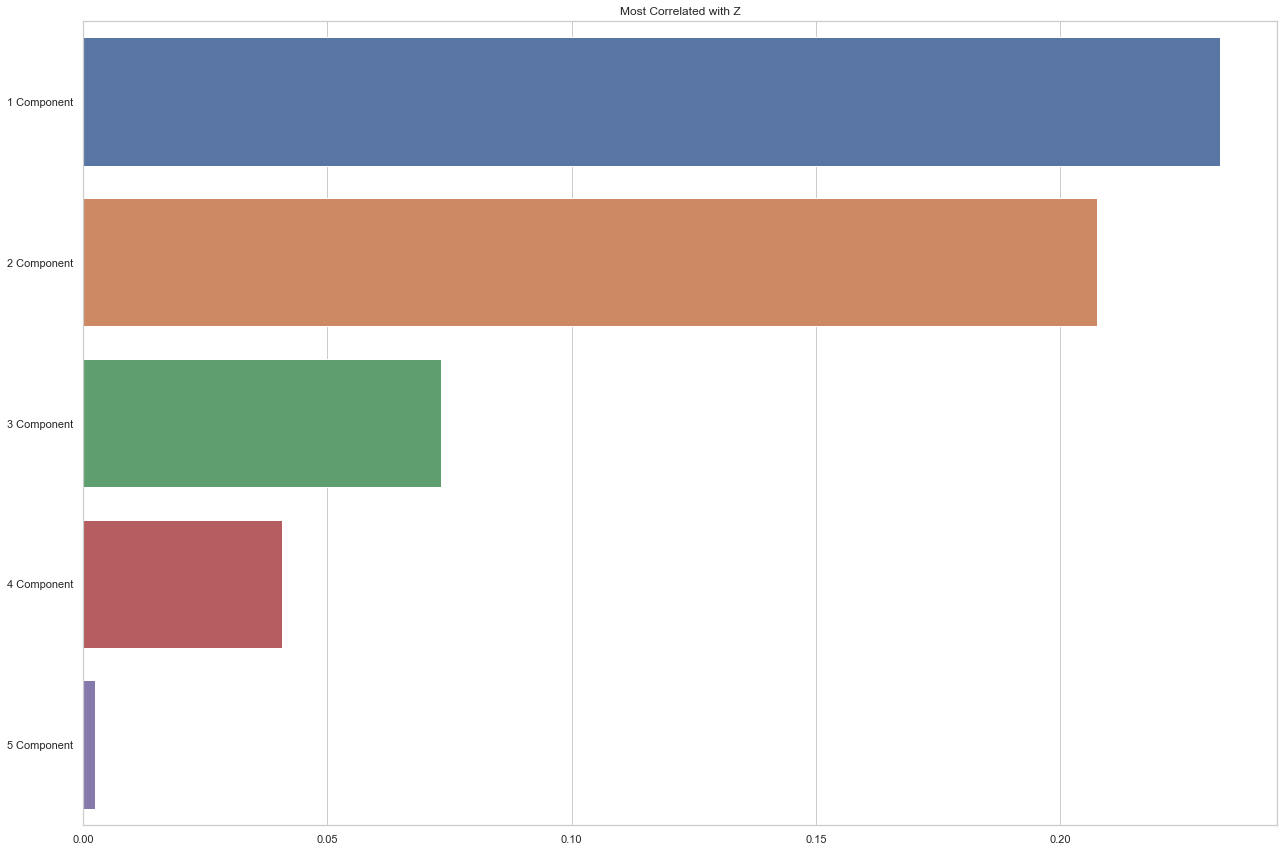

In [59]:
plt.figure(figsize=(18,12))
correlations =corrmat1.abs()['z'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with Z')
plt.tight_layout()

<Figure size 1152x576 with 0 Axes>

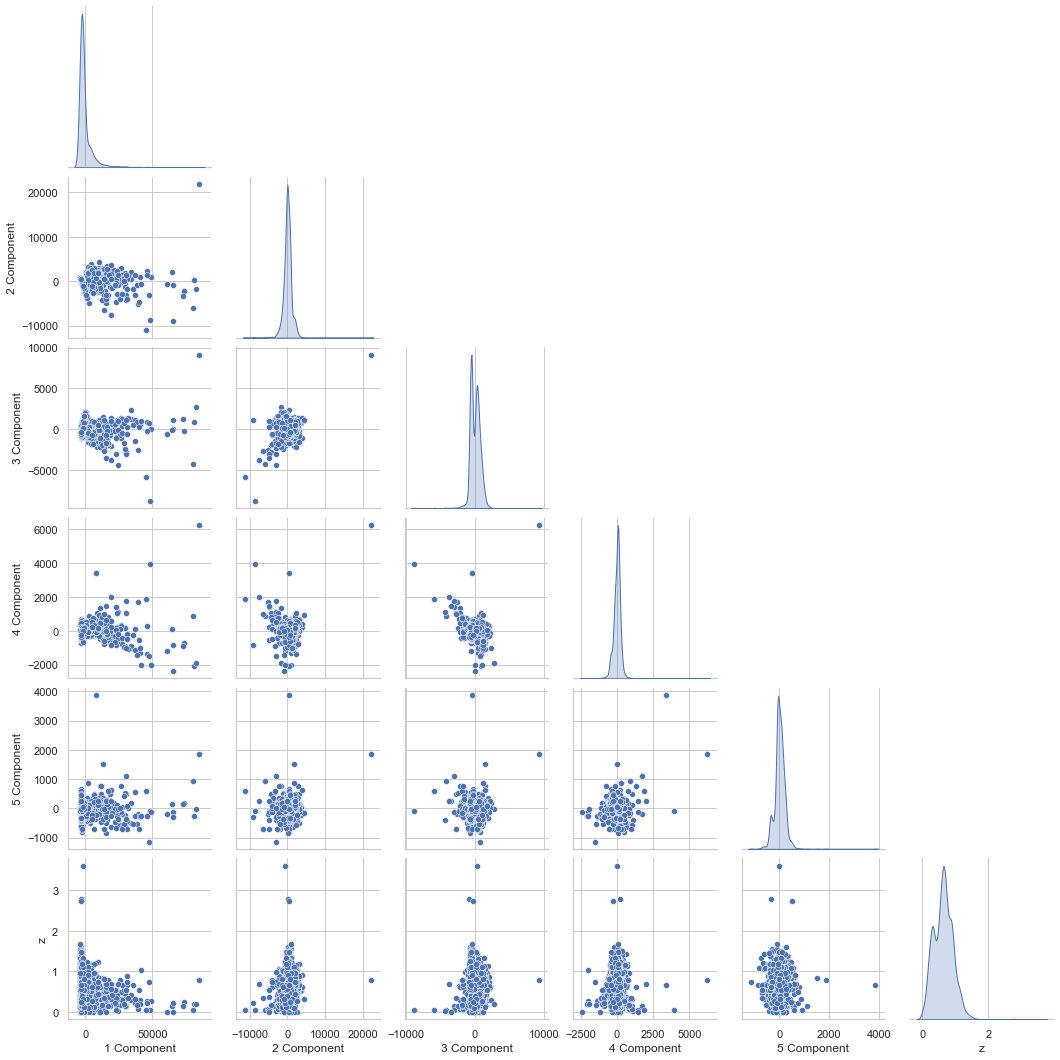

In [60]:
plt.figure(figsize=(16,8))
sns.pairplot(new_components,diag_kind= "kde",corner= True)

## Machine Learning

In [61]:
rob_scaler1 = RobustScaler()
rob_scaler2 = RobustScaler()

In [62]:
features =['MAG_AUTO_G','MAG_AUTO_R','MAG_AUTO_I','MAG_AUTO_Z','MAG_AUTO_Y',
            "WAVG_MAG_PSF_G","WAVG_MAG_PSF_R","WAVG_MAG_PSF_I","WAVG_MAG_PSF_Z","WAVG_MAG_PSF_Y"]

X = vvds[features].values
y = vvds["z"].values

#X = rob_scaler1.fit_transform(X)
#y = rob_scaler2.fit_transform(y.reshape(-1,1))

In [63]:
X_train, X_test,y_train, y_test = tts_split(X,y,0.3)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Deep Learning methods

In [65]:
EarlyStop = EarlyStopping(monitor='rmse_ann', mode='min', patience=10)

In [66]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.45),
                       Dense(25,kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])

In [67]:
cp_path = home+'/PHOTOzxcorr/notebooks/Checkpoint/cp.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [68]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann, metrics=['mse', 'mae', 'mape',rmse_ann])


In [69]:
history = ann_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val,y_val) ,batch_size=16, validation_split=0.1, callbacks=[cp,EarlyStop])


Epoch 1/1000
87/87 [==============================] - 0s 3ms/step - loss: 0.3125 - mse: 0.1567 - mae: 0.3109 - mape: 1189958.5000 - rmse_ann: 0.3109 - val_loss: 0.2270 - val_mse: 0.0793 - val_mae: 0.2256 - val_mape: 58.7398 - val_rmse_ann: 0.2256
Epoch 2/1000
87/87 [==============================] - 0s 1ms/step - loss: 0.2416 - mse: 0.0985 - mae: 0.2403 - mape: 2759633.0000 - rmse_ann: 0.2403 - val_loss: 0.2319 - val_mse: 0.0831 - val_mae: 0.2307 - val_mape: 56.0762 - val_rmse_ann: 0.2307
Epoch 3/1000
87/87 [==============================] - 0s 1ms/step - loss: 0.2309 - mse: 0.0923 - mae: 0.2297 - mape: 2728863.7500 - rmse_ann: 0.2297 - val_loss: 0.2427 - val_mse: 0.0919 - val_mae: 0.2417 - val_mape: 53.0244 - val_rmse_ann: 0.2417
Epoch 4/1000
87/87 [==============================] - 0s 1ms/step - loss: 0.2341 - mse: 0.0917 - mae: 0.2331 - mape: 2734230.0000 - rmse_ann: 0.2331 - val_loss: 0.2336 - val_mse: 0.0846 - val_mae: 0.2327 - val_mape: 55.8348 - val_rmse_ann: 0.2327
Epoch 5/1000

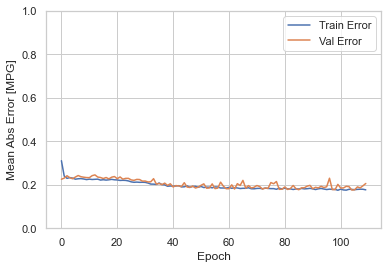

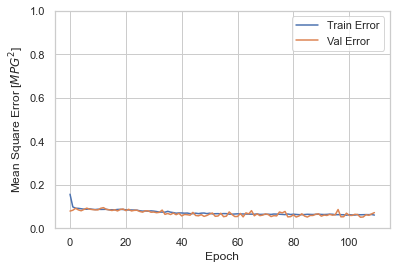

In [70]:
plot_history(history)

In [71]:
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann))

26/26 [==============================] - 0s 666us/step - loss: 0.1942 - mse: 0.0630 - mae: 0.1934 - mape: 3388022.7500 - rmse_ann: 0.1934
Testing set Mean Abs Error:  0.06 


Testing set Root Mean Abs Error:  0.19 


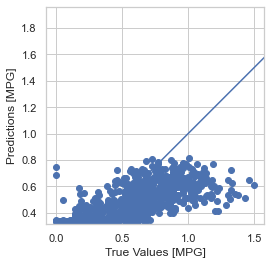

In [72]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


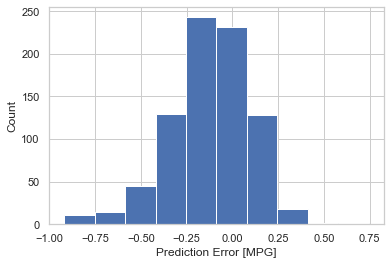

In [73]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [74]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
#print("Restored model, accuracy: {:5.2f}%".format(100 * mae))

26/26 [==============================] - 0s 654us/step - loss: 0.1669 - mse: 0.0463 - mae: 0.1661 - mape: 4060483.2500 - rmse_ann: 0.1661
Testing set Mean Abs Error:  0.05 MPG


In [75]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=1000,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_val, y_val))

Epoch 1/1000
48/48 [==============================] - 0s 4ms/step - loss: 0.0670 - mse: 0.0662 - mae: 0.1872 - mape: 2670078.7500 - val_loss: 0.0613 - val_mse: 0.0605 - val_mae: 0.1722 - val_mape: 4906464.5000
Epoch 2/1000
 1/48 [..............................] - ETA: 0s - loss: 0.0621 - mse: 0.0613 - mae: 0.1966 - mape: 71.0524
Epoch 00002: saving model to /home/rafael/PHOTOzxcorr/notebooks/Checkpoint/cp-0002.ckpt
48/48 [==============================] - 0s 1ms/step - loss: 0.0611 - mse: 0.0603 - mae: 0.1777 - mape: 2641910.5000 - val_loss: 0.0608 - val_mse: 0.0599 - val_mae: 0.1726 - val_mape: 5429672.5000
Epoch 3/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.0623 - mse: 0.0615 - mae: 0.1799 - mape: 2413069.2500 - val_loss: 0.0601 - val_mse: 0.0592 - val_mae: 0.1702 - val_mape: 5047841.0000
Epoch 4/1000
 1/48 [..............................] - ETA: 0s - loss: 0.0378 - mse: 0.0370 - mae: 0.1655 - mape: 41.5928
Epoch 00004: saving model to /home/rafael/PHOTOzxcorr

In [76]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/home/rafael/PHOTOzxcorr/notebooks/Checkpoint/cp-1000.ckpt'

In [77]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape, = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


26/26 [==============================] - 0s 897us/step - loss: 0.0502 - mse: 0.0489 - mae: 0.1760 - mape: 2706051.0000
Testing set Mean Abs Error:  0.05 MPG


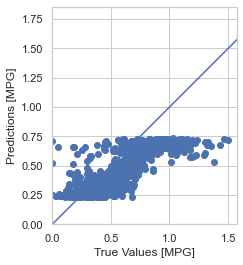

In [78]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [79]:
error = rmsle(y_test,test_predictions)
print("Testing set Mean Abs Error: ",error, " RMSE")

Testing set Mean Abs Error:  0.22110546  RMSE


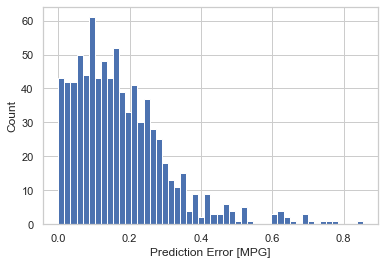

In [80]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

(0.0, 100.0)

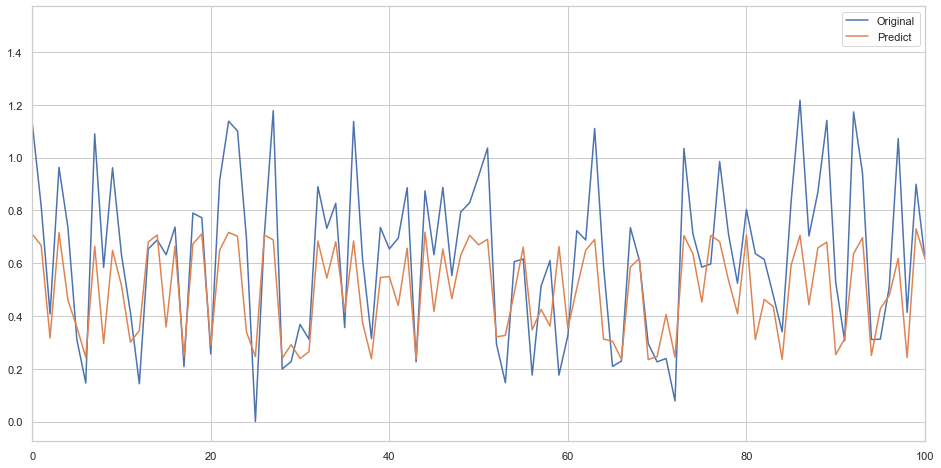

In [81]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()
plt.xlim(0,100)

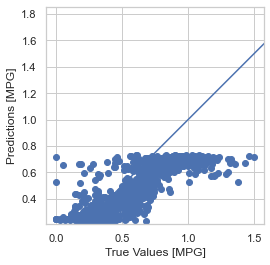

In [82]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


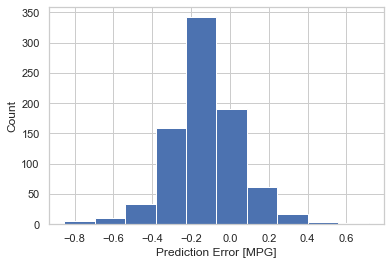

In [83]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## Color space


We now reconstruct the redshift using the colour space

In [84]:
EarlyStop = EarlyStopping(monitor='rmse_ann2', mode='min', patience=10)

In [50]:
def get_features_targets(data):
    features = np.zeros(shape=(len(data), 8))
    
    features[:, 0] = data['MAG_AUTO_G'] - data['MAG_AUTO_R']
    features[:, 1] = data['MAG_AUTO_R'] - data['MAG_AUTO_I']
    features[:, 2] = data['MAG_AUTO_I'] - data['MAG_AUTO_Z']
    features[:, 3] = data['MAG_AUTO_Z'] - data['MAG_AUTO_Y']
    features[:, 4] = data['WAVG_MAG_PSF_G'] - data['WAVG_MAG_PSF_R']
    features[:, 5] = data['WAVG_MAG_PSF_R'] - data['WAVG_MAG_PSF_I']
    features[:, 6] = data['WAVG_MAG_PSF_I'] - data['WAVG_MAG_PSF_Z']
    features[:, 7] = data['WAVG_MAG_PSF_Z'] - data['WAVG_MAG_PSF_Y']

    
    
    targets = data['z']
    return features, targets


In [86]:
X,y = get_features_targets(vvds)


In [87]:
X_train, X_test,y_train, y_test = tts_split(X,y.values,0.3)

In [88]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [89]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.45),
                       Dense(25,kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])

In [90]:
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                225       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)                650       
_________________________________________________________________
output (Dense)               (None, 1)                 26        
Total params: 973
Trainable params: 973
Non-trainable params: 0
________________________________________________________

In [91]:
cp_path = home+'/PHOTOzxcorr/notebooks/Checkpoint/cp_colour.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [92]:
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann2, metrics=['mse', 'mae', 'mape',rmse_ann2])

In [93]:
history = ann_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val,y_val) ,batch_size=16, validation_split=0.1, callbacks=[cp,EarlyStop])

Epoch 1/1000
87/87 [==============================] - 0s 3ms/step - loss: 0.3894 - mse: 0.2424 - mae: 0.3889 - mape: 2024547.3750 - rmse_ann2: 0.3889 - val_loss: 0.2039 - val_mse: 0.0675 - val_mae: 0.2034 - val_mape: 3196394.5000 - val_rmse_ann2: 0.2034
Epoch 2/1000
87/87 [==============================] - 0s 1ms/step - loss: 0.2129 - mse: 0.0845 - mae: 0.2123 - mape: 3155494.2500 - rmse_ann2: 0.2123 - val_loss: 0.1574 - val_mse: 0.0433 - val_mae: 0.1568 - val_mape: 3540117.5000 - val_rmse_ann2: 0.1568
Epoch 3/1000
87/87 [==============================] - 0s 1ms/step - loss: 0.1884 - mse: 0.0730 - mae: 0.1878 - mape: 3756013.7500 - rmse_ann2: 0.1878 - val_loss: 0.1616 - val_mse: 0.0412 - val_mae: 0.1610 - val_mape: 3258386.5000 - val_rmse_ann2: 0.1610
Epoch 4/1000
87/87 [==============================] - 0s 1ms/step - loss: 0.1817 - mse: 0.0687 - mae: 0.1811 - mape: 3953584.0000 - rmse_ann2: 0.1811 - val_loss: 0.1453 - val_mse: 0.0369 - val_mae: 0.1446 - val_mape: 3375124.7500 - val_rm

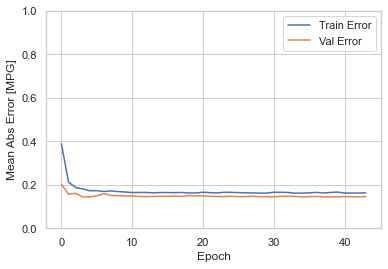

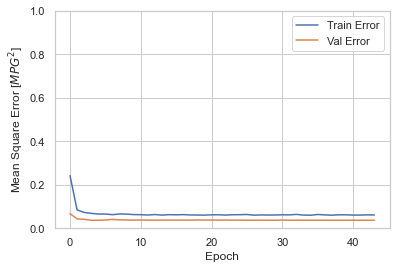

In [94]:
plot_history(history)

In [95]:
loss, mae, mse,mape,rmse_ann2 = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Mean Abs Error: {:5.2f} ".format(rmse_ann2))

26/26 [==============================] - 0s 635us/step - loss: 0.1476 - mse: 0.0415 - mae: 0.1470 - mape: 5335939.5000 - rmse_ann2: 0.1470
Testing set Mean Abs Error:  0.04 


Testing set Mean Abs Error:  0.15 


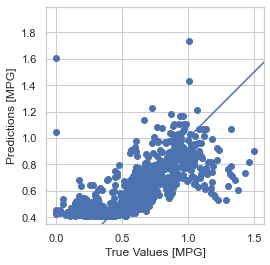

In [96]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


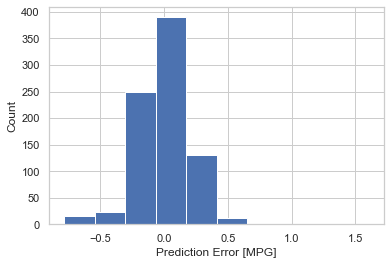

In [97]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [98]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann2 = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

26/26 [==============================] - 0s 638us/step - loss: 0.1479 - mse: 0.0425 - mae: 0.1473 - mape: 5597388.0000 - rmse_ann2: 0.1473
Testing set Mean Abs Error:  0.04 MPG


Testing set Root Mean Abs Error:  0.15 


In [99]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}_colour.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=1000,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_val, y_val))

Epoch 1/1000
48/48 [==============================] - 0s 5ms/step - loss: 0.0596 - mse: 0.0590 - mae: 0.1625 - mape: 3699842.7500 - val_loss: 0.0373 - val_mse: 0.0367 - val_mae: 0.1447 - val_mape: 3646368.0000
Epoch 2/1000
 1/48 [..............................] - ETA: 0s - loss: 0.0876 - mse: 0.0870 - mae: 0.2239 - mape: 91.7661
Epoch 00002: saving model to /home/rafael/PHOTOzxcorr/notebooks/Checkpoint/cp-0002_colour.ckpt
48/48 [==============================] - 0s 1ms/step - loss: 0.0605 - mse: 0.0599 - mae: 0.1622 - mape: 4413298.0000 - val_loss: 0.0375 - val_mse: 0.0369 - val_mae: 0.1433 - val_mape: 3692956.2500
Epoch 3/1000
48/48 [==============================] - 0s 1ms/step - loss: 0.0600 - mse: 0.0594 - mae: 0.1632 - mape: 4062632.2500 - val_loss: 0.0371 - val_mse: 0.0365 - val_mae: 0.1430 - val_mape: 3620577.7500
Epoch 4/1000
 1/48 [..............................] - ETA: 0s - loss: 0.0313 - mse: 0.0307 - mae: 0.1381 - mape: 33.0076
Epoch 00004: saving model to /home/rafael/PHOT

In [100]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/home/rafael/PHOTOzxcorr/notebooks/Checkpoint/cp-1000_colour.ckpt'

In [101]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

26/26 [==============================] - 0s 922us/step - loss: 0.0319 - mse: 0.0301 - mae: 0.1229 - mape: 3490037.7500
Testing set Mean Abs Error:  0.03 MPG


Testing set Root Mean Abs Error:  0.15 


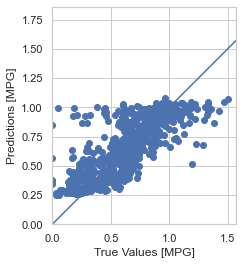

In [102]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [103]:
error = rmsle(y_test,test_predictions)
print("Testing set Mean Abs Error: ",error, " RMSE")

Testing set Mean Abs Error:  0.17352206  RMSE


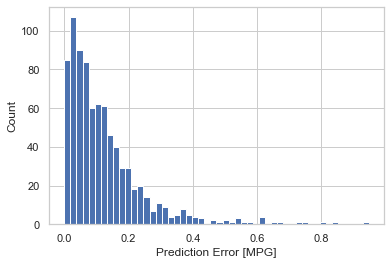

In [104]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

(0.0, 50.0)

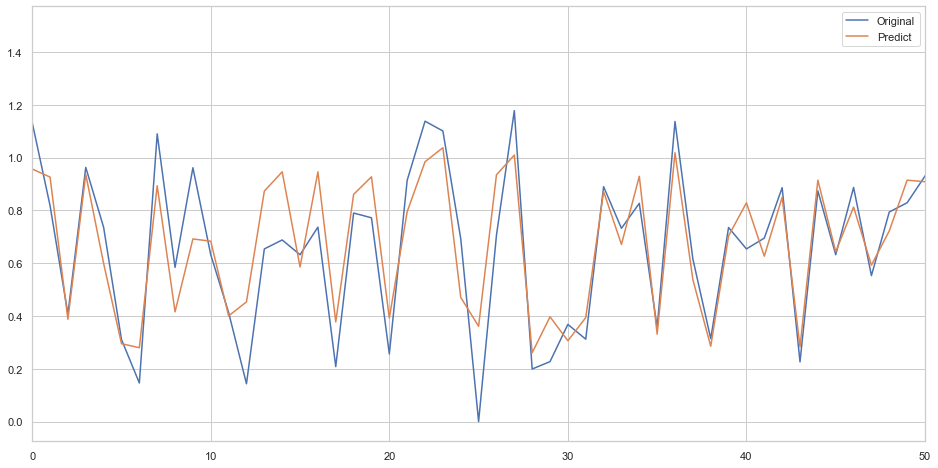

In [105]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()
plt.xlim(0,50)

## New method

Now we will add a some features to the color space and then try to estimate the Redshift

In [51]:
X,y = get_features_targets(vvds)


In [52]:
EarlyStop = EarlyStopping(monitor='rmse_ann3', mode='min', patience=10)

In [ ]:
#retirar wavg_psg

In [53]:
X = np.concatenate((X,vvds["MAG_AUTO_I"].values.reshape(-1,1)),axis = 1 ) # não necessario duas mag,
X = np.concatenate((X,vvds["MAG_AUTO_R"].values.reshape(-1,1)),axis = 1 )

In [54]:
X.shape

(2742, 10)

In [55]:
X_train, X_test,y_train, y_test = tts_split(X,y.values,0.3)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [57]:
X_train

array([[ 2.98799133e+00,  1.09013939e+00,  8.60603333e-01, ...,
         2.50066757e-01,  2.16288567e+01,  2.27189960e+01],
       [ 4.75264549e+00,  1.47214317e+00,  3.67660522e-01, ...,
         5.99750519e-01,  2.21304226e+01,  2.36025658e+01],
       [ 5.71340561e-01,  3.11880112e-01,  5.64048767e-01, ...,
         9.45726395e-01,  2.22230053e+01,  2.25348854e+01],
       ...,
       [ 2.34738159e+00,  8.85450363e-01, -3.53813171e-03, ...,
         1.51426697e+00,  2.29397030e+01,  2.38251534e+01],
       [ 1.58874512e+00,  7.65508652e-01,  1.79901123e-01, ...,
         9.40135956e-01,  2.25962524e+01,  2.33617611e+01],
       [ 8.18468094e-01,  3.00348282e-01,  1.83292389e-01, ...,
        -4.63161469e-02,  2.02522392e+01,  2.05525875e+01]])

(array([ 14.,  14.,  40.,  59.,  58., 131.,  53.,  66.,  55., 109., 120.,
        141., 152.,  83.,  72., 121.,  66.,  48.,  30.,  18.,  33.,  17.,
         13.,   4.,   8.,   3.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.        , 0.05562   , 0.11124   , 0.16686   , 0.22248   ,
        0.27809998, 0.33372   , 0.38933998, 0.44496   , 0.50057995,
        0.55619997, 0.61182   , 0.66744   , 0.72305995, 0.77867997,
        0.8343    , 0.88992   , 0.94553995, 1.0011599 , 1.05678   ,
        1.1123999 , 1.16802   , 1.22364   , 1.2792599 , 1.33488   ,
        1.3905    , 1.4461199 , 1.50174   , 1.5573599 , 1.6129799 ,
        1.6686    , 1.7242199 , 1.77984   , 1.83546   , 1.8910799 ,
        1.9467    , 2.0023198 , 2.05794   , 2.11356   , 2.16918   ,
        2.2247999 , 2.2804198 , 2.33604   , 2.39166   , 2.44728   ,
        2.5029    , 2.5585198 , 2.6141398 , 2.

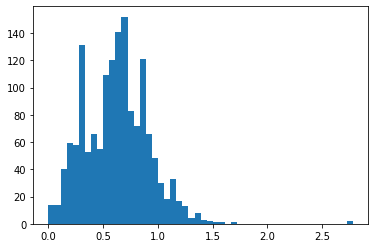

In [60]:
plt.hist(y_train,bins = 50)

(array([ 6.,  4.,  3.,  3., 12., 14., 21., 20., 18., 22., 43., 22.,  9.,
        18., 30., 11., 13., 49., 21., 30., 59., 35., 44., 33., 38., 15.,
        25., 11., 24., 33., 21., 12., 23., 12., 16.,  9.,  9.,  8.,  2.,
         8.,  4.,  1.,  0.,  3.,  4.,  1.,  1.,  1.,  1.,  1.]),
 array([0.        , 0.02996   , 0.05992   , 0.08988   , 0.11984   ,
        0.1498    , 0.17976001, 0.20972   , 0.23968   , 0.26964   ,
        0.2996    , 0.32956   , 0.35952002, 0.38948   , 0.41944   ,
        0.4494    , 0.47936   , 0.50932   , 0.53928   , 0.56924003,
        0.5992    , 0.62916   , 0.65912   , 0.68908   , 0.71904004,
        0.749     , 0.77896   , 0.80892   , 0.83888   , 0.86884004,
        0.8988    , 0.92876   , 0.95872   , 0.98868   , 1.01864   ,
        1.0486    , 1.07856   , 1.10852   , 1.1384801 , 1.16844   ,
        1.1984    , 1.22836   , 1.25832   , 1.28828   , 1.31824   ,
        1.3482001 , 1.37816   , 1.40812   , 1.4380801 , 1.46804   ,
        1.498     ], dtype=float32),

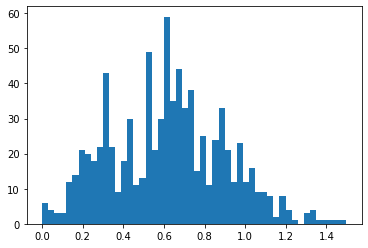

In [61]:
plt.hist(y_test,bins= 50)

In [112]:
n_inputs = X_train.shape[1]
ann_model = Sequential([Dense(n_inputs,input_shape = X_train.shape[1:],kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.05),
                       Dense(25, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)),
                       Dropout(0.45),
                       Dense(25,kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                              bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(1e-5)) ,
                       Dense(1,activation = None,name = "output")
                       ])

In [113]:
ann_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 25)                275       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                650       
_________________________________________________________________
output (Dense)               (None, 1)                 26        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
____________________________________________________

In [114]:
cp_path = home+'/PHOTOzxcorr/notebooks/Checkpoint/cp_colour.ckpt'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [117]:
opt = ks.optimizers.Adam(lr=0.001, decay=5e-4)
#opt = tf.keras.optimizers.RMSprop(0.001)
ann_model.compile(optimizer=opt, loss=rmse_ann3, metrics=['mse', 'mae', 'mape',rmse_ann3])

In [118]:
history = ann_model.fit(X_train, y_train, epochs=1000, validation_data=(X_val,y_val) ,batch_size=16, validation_split=0.1, callbacks=[cp,EarlyStop])

Epoch 1/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.3469 - mse: 0.1913 - mae: 0.3463 - mape: 2427028.5000 - rmse_ann3: 0.3463 - val_loss: 0.2355 - val_mse: 0.0817 - val_mae: 0.2350 - val_mape: 3723665.5000 - val_rmse_ann3: 0.2350
Epoch 2/1000
87/87 [==============================] - 0s 2ms/step - loss: 0.2326 - mse: 0.0918 - mae: 0.2321 - mape: 3520664.5000 - rmse_ann3: 0.2321 - val_loss: 0.2312 - val_mse: 0.0794 - val_mae: 0.2307 - val_mape: 3724899.0000 - val_rmse_ann3: 0.2307
Epoch 3/1000
87/87 [==============================] - 0s 2ms/step - loss: 0.2185 - mse: 0.0815 - mae: 0.2180 - mape: 3385278.7500 - rmse_ann3: 0.2180 - val_loss: 0.2167 - val_mse: 0.0709 - val_mae: 0.2162 - val_mape: 3908488.2500 - val_rmse_ann3: 0.2162
Epoch 4/1000
87/87 [==============================] - 0s 2ms/step - loss: 0.2077 - mse: 0.0756 - mae: 0.2072 - mape: 3037828.2500 - rmse_ann3: 0.2072 - val_loss: 0.1928 - val_mse: 0.0592 - val_mae: 0.1923 - val_mape: 4433196.0000 - val_rm

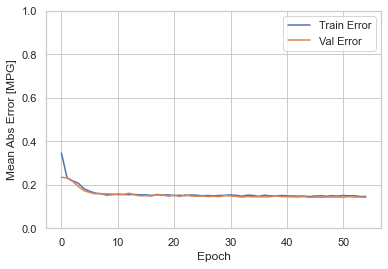

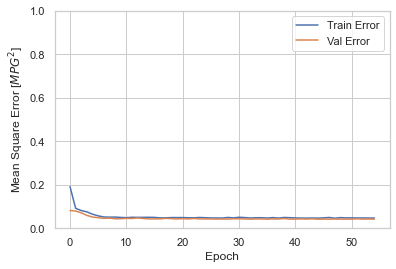

In [119]:
plot_history(history)

In [120]:
loss, mae, mse,mape,rmse_ann2 = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} ".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

26/26 [==============================] - 0s 2ms/step - loss: 0.1335 - mse: 0.0351 - mae: 0.1327 - mape: 4822726.0000 - rmse_ann3: 0.1327
Testing set Mean Abs Error:  0.04 


Testing set Mean Abs Error:  0.13 


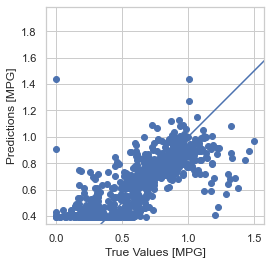

In [121]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


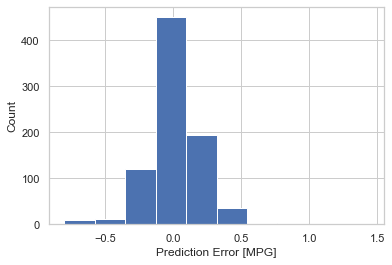

In [122]:
error = test_predictions - y_test
plt.hist(error)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Now we gonna use the this pre-trained model, to try a improvoment

In [123]:
# Loads the weights
ann_model.load_weights(cp_path)

# Re-evaluate the model
loss, mae, mse,mape,rmse_ann2 = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

26/26 [==============================] - 0s 2ms/step - loss: 0.1347 - mse: 0.0350 - mae: 0.1339 - mape: 4809572.0000 - rmse_ann3: 0.1339
Testing set Mean Abs Error:  0.04 MPG


Testing set Root Mean Abs Error:  0.13 


In [124]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = home+"/PHOTOzxcorr/notebooks/Checkpoint/cp-{epoch:04d}_colour.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 16

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
# model = create_model()

# Save the weights using the `checkpoint_path` format
ann_model.save_weights(checkpoint_path.format(epoch=0))
## New optimizer
opt_new = tf.keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")

ann_model.compile(optimizer=opt_new, loss = "mse", metrics=['mse', 'mae', 'mape'])
# Train the model with the new callback
ann_model.fit(X_train, 
          y_train,
          epochs=1000,
          batch_size = 32,
          callbacks=[cp_callback],
          validation_data=(X_val, y_val))

Epoch 1/1000
48/48 [==============================] - 1s 13ms/step - loss: 0.0477 - mse: 0.0469 - mae: 0.1471 - mape: 4089995.5000 - val_loss: 0.0639 - val_mse: 0.0631 - val_mae: 0.1460 - val_mape: 1918841.1250
Epoch 2/1000
19/48 [==========>...................] - ETA: 0s - loss: 0.0509 - mse: 0.0501 - mae: 0.1525 - mape: 668719.2500  
Epoch 00002: saving model to /home/rafael/PHOTOzxcorr/notebooks/Checkpoint/cp-0002_colour.ckpt
48/48 [==============================] - 0s 4ms/step - loss: 0.0490 - mse: 0.0483 - mae: 0.1503 - mape: 4334474.0000 - val_loss: 0.0637 - val_mse: 0.0630 - val_mae: 0.1468 - val_mape: 1893523.8750
Epoch 3/1000
48/48 [==============================] - 0s 4ms/step - loss: 0.0477 - mse: 0.0469 - mae: 0.1487 - mape: 3950264.0000 - val_loss: 0.0635 - val_mse: 0.0628 - val_mae: 0.1455 - val_mape: 1983822.1250
Epoch 4/1000
 1/48 [..............................] - ETA: 0s - loss: 0.0287 - mse: 0.0279 - mae: 0.1288 - mape: 37.9645
Epoch 00004: saving model to /home/rafa

In [125]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/home/rafael/PHOTOzxcorr/notebooks/Checkpoint/cp-1000_colour.ckpt'

In [126]:
# Load the previously saved weights
ann_model.load_weights(latest)

# Re-evaluate the model
loss, mae, mse,mape = ann_model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("\n")
print("Testing set Root Mean Abs Error: {:5.2f} ".format(rmse_ann2))

26/26 [==============================] - 0s 1ms/step - loss: 0.0320 - mse: 0.0306 - mae: 0.1256 - mape: 3801283.0000
Testing set Mean Abs Error:  0.03 MPG


Testing set Root Mean Abs Error:  0.13 


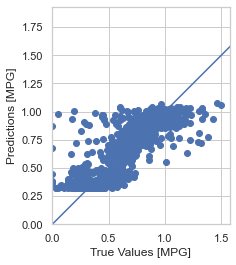

In [127]:
test_predictions = ann_model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [128]:
error = rmsle(y_test,test_predictions)
print("Testing set Mean Abs Error: ",error, " RMSE")
print("Testing set Mean Abs Error: ",mae, " RMSE")

Testing set Mean Abs Error:  0.17503047  RMSE


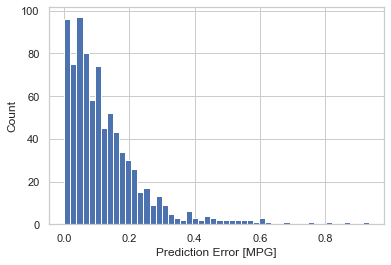

In [129]:
error = np.abs(test_predictions - y_test)
plt.hist(error,bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

(0.0, 50.0)

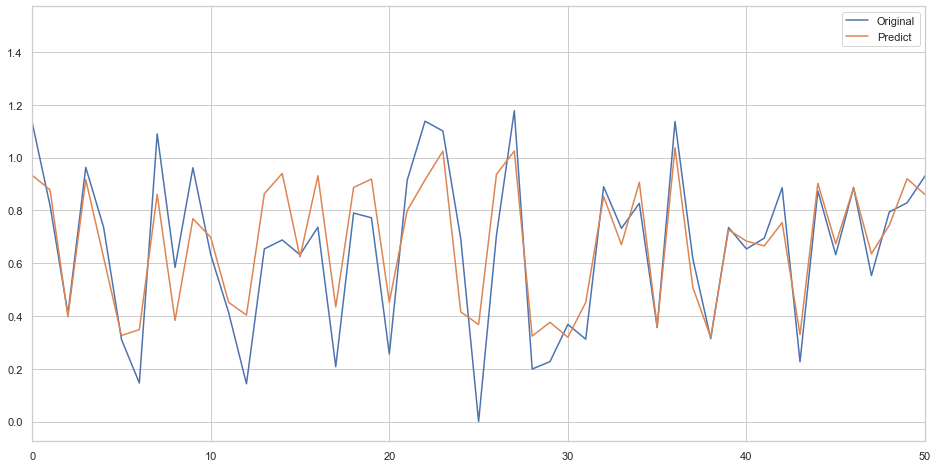

In [130]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label = "Original")
plt.plot(test_predictions,label = "Predict")
plt.legend()
plt.xlim(0,50)